In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyscf import ao2mo,gto, scf

from typing import Tuple


# qiskit
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD
from qiskit.algorithms import MinimumEigensolverResult

from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.opflow.primitive_ops import PauliOp, PauliSumOp
from qiskit.quantum_info import Pauli, SparsePauliOp

# qiskit nature
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

from qiskit_nature.settings import settings
settings.dict_aux_operators = True

#from qiskit import IBMQ
#from qiskit_nature.runtime import VQEClient
#from qiskit.providers.ibmq import least_busy
#from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

# useful??
#from qiskit_nature.algorithms import (GroundStateEigensolver,
#                                      NumPyMinimumEigensolverFactory)
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.opflow import TwoQubitReduction

def get_molecular_integrals(molecule):
    '''
    Calculates the 1-electron and 2-electron integrals.
    
    Args:   
        molecule : Mole 
            Ccorresponds to the molecule.
            
    Returns:
        h1_MO : ndarray
                Tensor corresponding to the 1-electron integral in the molecular basis.
        
        h2_MO : ndarray
                Tensor corresponding to the 2-electron integral in the molecular basis.

        n_particles: Tuple[int, int]
            Number of alpha and beta electrons.
        
        num_orb : int 
            Number of orbitals.

        nuclear_repulsion_energy : float
            Nuclear repulsion energy.
    '''
    
    mf = scf.RHF(molecule).run()

    # computing the 1e and 2e AO (atomic orbitals) integrals 
    h1 = molecule.intor_symmetric("int1e_nuc") + molecule.intor_symmetric("int1e_kin") 
    h2 = molecule.intor("int2e")
    # comment : add aosym (axis of symmetry) ???

    # transformations from AO to MO (molecular orbitals)
    h1_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff, h1, mf.mo_coeff)
    h2_MO = ao2mo.get_mo_eri(h2, mf.mo_coeff)

    #h2_MO = ao2mo.kernel(mol_h2, mf.mo_coeff, aosym="1") #alternative

    nuclear_repulsion_energy=molecule.energy_nuc()
    num_particles = molecule.nelec
    num_orb = h1.shape[0]

    return h1_MO, h2_MO, num_particles, num_orb, nuclear_repulsion_energy


def get_qubit_op(coordinates):
    '''
    Calculates the Hamiltonian as the sum of Pauli operators as a function
    of the coordinates of the atoms.
    
    Args:
        coordinates : ndarray
            Array containing the positions of the atoms constituing the molecule.
        
    
    Returns:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
    '''
    
    mol = gto.M(
                atom = [['H',(coordinates[0], coordinates[1], 0.0)], 
                        ['H',(coordinates[2], coordinates[3], 0.0)],
                        ['H',(coordinates[4], coordinates[5], 0.0)]],
                basis = 'sto3g',
                charge = 1,
                spin = 0,
                symmetry = True,
                verbose = 2 # control the print level of PySCF globally
    )

    h1_MO,h2_MO,nelec,norb,ecore = get_molecular_integrals(mol)

    # Define an ElectronicEnergy instance containing the 1e and 2e integrals
    electronic_energy = ElectronicEnergy.from_raw_integrals(
            h1_MO, ao2mo.restore(1, h2_MO, norb)
        )
    electronic_energy.nuclear_repulsion_energy = ecore

    # Define an ElectronicStructureProblem
    problem = ElectronicStructureProblem(electronic_energy)

    second_q_ops = problem.second_q_ops()     # get second quantized operators
    problem.num_spatial_orbitals = norb  # define number of orbitals
    problem.num_particles = nelec        # define number of particles 
    
    problem.basis = ElectronicBasis.MO 
    
    problem.molecule=MoleculeInfo(symbols=[mol.atom_symbol(i) for i in range(mol.nbas)], 
                                  coords=mol.atom_coords())
    FC_transformer=FreezeCoreTransformer(freeze_core=True)
    problem = FC_transformer.transform(problem)
    
    # TODO we need to give info about the molecule to use FreezeCoreTransformer 
    # question : how to do it in a smart way ? at the initialization ??
    
    hamiltonian = second_q_ops[0]  # Set electronic part of Hamiltonian
    hamiltonian = (hamiltonian + FermionicOp({"": ecore}, num_spin_orbitals=norb)) # add Nuclear Repulsion Energy
    #print("Hamiltonian :\n", hamiltonian) # print for checking purposes
    
    mapper = ParityMapper()  # Set Mapper
    
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    qubit_op = converter.convert(hamiltonian, nelec)
    #print("q_op :\n", qubit_op) # print for checking purposes
    

    return qubit_op, nelec, norb, problem, converter

def calc_ground_state(qubit_op,nelec,norb,problem,converter) :
    '''
    Calculates the ground state and the ground energy of the Hamiltonian.
    
    Args:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
        
    
    Returns:
        ground_state : CircuitStateFn
            Ground state of the Hamiltonian.
            
        min_eng : float
            Ground energy of the Hamiltonian.
    '''

    backend = BasicAer.get_backend("statevector_simulator")
    quantum_instance = QuantumInstance(backend)
    optimizer = SLSQP(maxiter=400)

    init_state = HartreeFock(num_spatial_orbitals=norb, 
                                num_particles=nelec, 
                                qubit_converter=converter
                            )
    
    var_form = UCCSD(qubit_converter=converter,
                        num_particles=nelec,
                        num_spatial_orbitals=norb, 
                        initial_state=init_state
                        )

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    min_eng = vqe_result.eigenvalue.real
    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params) 
#     vqe_ground_state = CircuitStateFn(vqe_ground)
    
    return vqe_ground, min_eng

In [2]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.01 #removed the angst, since coordinates are given in angst


from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import time #to see which part of code takes the longest
import multiprocessing


#calculate centre of mass (currently for equal particle masses)
def calc_COM(coordinates):
    #print(coordinates)
    r_array = np.array_split(coordinates,3)
    COM = (r_array[0] + r_array[1] + r_array[2])/3
    
    return COM

#task to calculate expectation value
def task1(string, q_instance, psi_0):

    Obs = PauliOp(Pauli(string))
    measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    E = sampler.eval().real
        
    return E

#task to calculate operator from coordinates
def task2(coordinates):
    
    #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
    (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0])
    #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
    (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[1])
        
    qubit_op_plus = qubit_op_plus #TODO:number of I's needs to be changed according to number of qubits
    qubit_op_minus = qubit_op_minus
       
    #op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
    op =  -(qubit_op_plus - qubit_op_minus)

                    
    op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
    #print(op_list)    
    #construct dict from list
    op_dict = {}
    for (PauliString,coeff) in op_list:

        if PauliString in op_dict:
            op_dict[PauliString] += coeff
        else:
            op_dict[PauliString] = coeff
    
    return op, op_dict
 
def parallel_operators(coordinates,basis_set):
    
    
    coordinate_list = []
    
    v0_normed = basis_set[0]
    v0_orth = basis_set[1]
    
    v1_normed = basis_set[2]
    v1_orth = basis_set[3]

    v2_normed = basis_set[4]
    v2_orth = basis_set[5]
    
    displ_coords_0_a = np.array([v0_normed[0]*dR,v0_normed[1]*dR,0,0,0,0])
    displ_coords_0_b = np.array([v0_orth[0]*dR,v0_orth[1]*dR,0,0,0,0])
    displ_coords_1_a = np.array([0,0,v1_normed[0]*dR,v1_normed[1]*dR,0,0])
    displ_coords_1_b = np.array([0,0,v1_orth[0]*dR,v1_orth[1]*dR,0,0])
    displ_coords_2_a = np.array([0,0,0,0,v2_normed[0]*dR,v2_normed[1]*dR])
    displ_coords_2_b = np.array([0,0,0,0,v2_orth[0]*dR,v2_orth[1]*dR])

    coordinate_list.append([coordinates + displ_coords_0_a,coordinates - displ_coords_0_a])
    coordinate_list.append([coordinates + displ_coords_0_b,coordinates - displ_coords_0_b])
    coordinate_list.append([coordinates + displ_coords_1_a,coordinates - displ_coords_1_a])
    coordinate_list.append([coordinates + displ_coords_1_b,coordinates - displ_coords_1_b])
    coordinate_list.append([coordinates + displ_coords_2_a,coordinates - displ_coords_2_a])
    coordinate_list.append([coordinates + displ_coords_2_b,coordinates - displ_coords_2_b])
    
    #dR_list = v0_normed.tolist() + v1_normed.tolist() + v2_normed.tolist()
    
    dR_list = [dR,dR,dR,dR,dR,dR]
    #print(dR_list)
    #for i in range(len(coordinates)):
        
        #coordinate_list.append([coordinates[0:i]+[(coordinates[i]+dR_list[i])]+coordinates[i+1:],coordinates[0:i]+[(coordinates[i]-dR_list[i])]+coordinates[i+1:]])
    
    #print(coordinate_list)
    with multiprocessing.Pool() as pool:
         ops,op_coeffs = zip(*pool.map(task2, coordinate_list))
    
    #print(ops)
    return ops, op_coeffs

def sequential_operators(coordinates):
    ops = []
    op_coeffs = []
    
    for i in range(len(coordinates)):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  -(qubit_op_plus - qubit_op_minus).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        ops.append(op)
        op_coeffs.append(op_dict)
    #print(ops)
    return ops, op_coeffs

def parallel_expectations(exp_dict, op_set, q_instance, psi_0):

    triples = []
    for op in op_set:
        triple = (op,q_instance,psi_0)
        triples.append(triple)

    Es = 0
    with multiprocessing.Pool() as pool:
        Es = pool.starmap(task1, triples)

    for i in range(len(Es)):
        exp_dict[triples[i][0]]=Es[i]

    return 0

def sequential_expectations(exp_dict, op_set, q_instance, psi_0):

    for pauli_string in op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        exp_dict[pauli_string] = E

    return 0

def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter)
    
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 128, basis_set_this=None):
  
    
    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator')
            #backend.set_options(max_job_size=1, executor = euler_client)
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)   
    
    start = time.time()
    

    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    
    end = time.time()
    
    
    time_psi_0 = end - start
    #print("Took " + str(time_psi_0) + " s to calculate the ground state")
    forces = np.zeros(num_coord)
    coordinates = coordinates.tolist()
    
    
    coordinates_this = np.array(coordinates)
    COM = calc_COM(coordinates_this)
    coords = np.array_split(coordinates_this,3)
    #print(coords)
    #print(COM)
    v0 = coords[0] - COM
    v1 = coords[1] - COM
    v2 = coords[2] - COM
    
    v0_normed = np.array(v0/np.sqrt(v0[0]**2+v0[1]**2))
    v0_orth = np.array([v0_normed[1],-v0_normed[0]])
    
    v1_normed = np.array(v1/np.sqrt(v1[0]**2+v1[1]**2))
    v1_orth = np.array([v1_normed[1],-v1_normed[0]])

    v2_normed = np.array(v2/np.sqrt(v2[0]**2+v2[1]**2))
    v2_orth = np.array([v2_normed[1],-v2_normed[0]])
    
    basis_set = [v0_normed,v0_orth,v1_normed,v1_orth,v2_normed,v2_orth]
    #basis_set = basis_set_this

    transform_matrix = np.array([[basis_set[0][0],basis_set[1][0],0,0,0,0],
                                 [basis_set[0][1],basis_set[1][1],0,0,0,0],
                                 [0,0,basis_set[2][0],basis_set[3][0],0,0],
                                 [0,0,basis_set[2][1],basis_set[3][1],0,0],
                                 [0,0,0,0,basis_set[4][0],basis_set[5][0]],
                                 [0,0,0,0,basis_set[4][1],basis_set[5][1]]])
    
    transform_matrix_inv = np.linalg.inv(transform_matrix)
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons)
    #replace parallel_ with sequential_ to see effect of parallelization
    force_ops,force_op_coeffs = parallel_operators(coordinates,basis_set)
    
    #for ops in force_ops:
        #print(len(ops))
        
    P1 = force_ops[0]
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
        
            P_prod = (P1@P1)
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    start = time.time()
    exp_dict = {} # dictionary with relevant expectation values
        
    #switch between parallel_ and sequential_ to see the effect
    
    parallel_expectations(exp_dict,pauli_op_set,q_instance,psi_0)
    

    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
    
    #forces[1] = 0
    #forces[3] = 0
    #forces[5] = 0
    forces_return = np.matmul(transform_matrix,np.array(forces))
    #print(forces)
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):

            Pij = force_ops[i]@force_ops[j]
            Pij_list = Pij.primitive.to_list()

            #add product expectation 
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
                    #subtract 
            COV[i,j] -= forces[i]*forces[j]

            #since COV is symmetric
            #if (i,j) != (0,0) and (i,j) != (2,2) and (i,j) != (4,4) and (i,j) != (0,2) and (i,j) != (0,4) and (i,j) != (2,0) and (i,j) != (2,4) and (i,j) != (4,0) and (i,j) != (4,2):
                #print("here")
                #print((i,j))
             #   COV[i,j] = 0
            
            if i < j:
                COV[j,i] = COV[i,j]
            
            
                
    #print(COV)            
    end = time.time()
    COV_1 = np.matmul(COV,transform_matrix)
    COV_2 = np.matmul(transform_matrix_inv,COV_1)
    COV_return = COV_2
    time_cov = end - start

    print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    #print(COV)
    
    return forces_return*Ha*(1/(2*dR*angst)),COV_return*(Ha*(1/(2*dR*angst)))**2

In [3]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def calc_COM(coordinates):
    #print(coordinates)
    r_array = np.array_split(coordinates,3)
    COM = (r_array[0] + r_array[1] + r_array[2])/3
    
    return COM

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))
    


def main():
    
    f = open("h3_rotated_basis_n_256000_raw.txt","w")
    
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    #initial velocity of atoms
    
    v_init_0 = np.array([0,0])
    v_init_1 = np.array([0,0])
    v_init_2 = np.array([0,0])

    v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

    #distances between atoms
    d = 0.8
    #rotation angle of the initial triangle
    b = 0/180*np.pi
    
    #initial positions of atoms, arrangement = equilateral triangle
    x1_init = np.array([-d/2*np.cos(b)+np.sin(b)*np.sqrt(3)/6*d,-d/2*np.sin(b)-np.cos(b)*np.sqrt(3)/6*d])+np.array([0,d*np.sqrt(3)/6])
    x2_init = np.array([d/2*np.cos(b)+np.sin(b)*np.sqrt(3)/6*d,d/2*np.sin(b)-np.cos(b)*np.sqrt(3)/6*d])+np.array([0,d*np.sqrt(3)/6])
    x3_init = np.array([-np.sin(b)*np.sqrt(3)/3*d,np.cos(b)*np.sqrt(3)/3*d])+np.array([0,d*np.sqrt(3)/6])
    
    
    init_pos0 = x1_init
    init_pos1 = x2_init
    init_pos2 = x3_init
    
    #print(distance(init_pos0,init_pos1))
    #print(distance(init_pos0,init_pos2))
    #print(distance(init_pos1,init_pos2))
    
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)

    #integrator timesteps
    timeB = 0
    timeE = 60
    times = np.arange(timeB*femto, timeE*femto, dt)
    #print(times)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
    delta = 0.05*dt
    #hold v_next
    v_next = None
    
    simulator = 'qasm'
    COM = calc_COM(init_pos)
    coords_loc = np.array_split(init_pos,3)
    forces_array = []
    velocities_array = []
    velocities_array.append(v_init.tolist())
    coords_array = []
    coords_array.append(init_pos.tolist())
    
    #print(coords)
    #print(COM)
    #v0 = coords_loc[0] - COM
    #v1 = coords_loc[1] - COM
    #v2 = coords_loc[2] - COM
    
    #v0_normed = np.array(v0/np.sqrt(v0[0]**2+v0[1]**2))
    #v0_orth = np.array([v0_normed[1],-v0_normed[0]])
    
    #v1_normed = np.array(v1/np.sqrt(v1[0]**2+v1[1]**2))
    #v1_orth = np.array([v1_normed[1],-v1_normed[0]])

    #v2_normed = np.array(v2/np.sqrt(v2[0]**2+v2[1]**2))
    #v2_orth = np.array([v2_normed[1],-v2_normed[0]])
    
    #basis_set = [v0_normed,v0_orth,v1_normed,v1_orth,v2_normed,v2_orth]
    basis_set = [0,0,0,0,0,0]
    for time in tqdm(times, desc='Progress: '):
        
        r = coords[-1]
        #print(r)
        
        (forces,COV) = calc_force_and_cov(r, simulator = simulator, shots = 256000,basis_set_this=basis_set)
        
        forces_array.append(forces.tolist())
        
        #print(COV)
        
        #COV = np.zeros((6,6))
        
        #angle1 = np.arctan(forces[1]/forces[0])/np.pi * 180
        #print(angle1)
        #print("f1 = " + str([forces[2],forces[3]]))
        #print("f2 = " + str([forces[4],forces[5]]))
        
        f1 = distance(np.array([forces[0],forces[1]]),np.array([0,0]))
        
        f2 = distance(np.array([forces[2],forces[3]]),np.array([0,0]))
        
        f3 = distance(np.array([forces[4],forces[5]]),np.array([0,0]))    
        
        print("f0,f1,f2 = " + str([f1,f2,f3]))
        
        #print(forces)
        #print(COV)
        
        if time == 0:

            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:

            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)
            
            coords.append(r_next)
        velocities_array.append(v_next.tolist())  
        coords_array.append(coords[-1].tolist())
        
        r = np.array_split(coords[-1],3)
        d01 = distance(r[0],r[1])
        d02 = distance(r[0],r[2])
        d12 = distance(r[1],r[2])
        print("d01,d02,d12 = " + str([d01,d02,d12]))
        
        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
    timess = times.tolist()
    timess.append(timeE*femto)
    f.write('times \n')
    f.write(str(timess) + "\n")
    f.write("coordinates \n")
    f.write(str(coords_array) + "\n")
    f.write("velocities \n")
    f.write(str(velocities_array) + "\n")
    f.write("forces \n")
    f.write(str(forces_array) + "\n")
    return (distance01,distance02,distance12,times) 

Progress:   0%|          | 1/300 [00:14<1:10:22, 14.12s/it]

Time to: Calculate Ground State - 2.05s, Get Pauli Ops - 4.55s, Calculate Pauli Expectation Values - 5.55s, Calculate Covariance - 1.62s
f0,f1,f2 = [1.1264009619686873e-08, 1.1264009619690638e-08, 1.1264009619681405e-08]
d01,d02,d12 = [0.8046730148402974, 0.8046730148402967, 0.8046730148402981]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   1%|          | 2/300 [00:28<1:11:59, 14.49s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 6.26s, Calculate Covariance - 2.36s
f0,f1,f2 = [1.210089870721599e-08, 1.2100898707214603e-08, 1.2100898707219112e-08]
d01,d02,d12 = [0.8144658801678226, 0.8144658801678223, 0.8144658801678244]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   1%|          | 3/300 [00:41<1:08:35, 13.86s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 3.66s, Calculate Pauli Expectation Values - 6.16s, Calculate Covariance - 2.42s
f0,f1,f2 = [1.0751042541380182e-08, 1.0751042541373348e-08, 1.0751042541368219e-08]
d01,d02,d12 = [0.8287918415603788, 0.8287918415603774, 0.8287918415603757]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   1%|▏         | 4/300 [00:56<1:08:50, 13.95s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 6.01s, Calculate Covariance - 2.4s
f0,f1,f2 = [1.0068384260671095e-08, 1.0068384260672955e-08, 1.0068384260667515e-08]
d01,d02,d12 = [0.8471121562968403, 0.8471121562968338, 0.847112156296828]


Progress:   2%|▏         | 5/300 [01:09<1:08:16, 13.89s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.58s, Calculate Pauli Expectation Values - 6.36s, Calculate Covariance - 1.76s
f0,f1,f2 = [7.420450207962071e-09, 7.4204502079718316e-09, 7.420450207968368e-09]
d01,d02,d12 = [0.869993639369894, 0.8699936393698753, 0.8699936393698792]


Progress:   2%|▏         | 6/300 [01:24<1:09:16, 14.14s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.5s, Calculate Pauli Expectation Values - 6.54s, Calculate Covariance - 2.25s
f0,f1,f2 = [6.796990745264786e-09, 6.796990745256267e-09, 6.796990745265942e-09]
d01,d02,d12 = [0.895034885442026, 0.8950348854420005, 0.8950348854420072]


Progress:   2%|▏         | 7/300 [01:38<1:09:06, 14.15s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.41s, Calculate Pauli Expectation Values - 6.08s, Calculate Covariance - 2.48s
f0,f1,f2 = [4.424991743943984e-09, 4.424991743939705e-09, 4.4249917439498204e-09]
d01,d02,d12 = [0.9191524885145148, 0.9191524885144712, 0.9191524885145032]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   3%|▎         | 8/300 [01:53<1:09:15, 14.23s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 6.39s, Calculate Covariance - 1.76s
f0,f1,f2 = [4.476495567660905e-09, 4.476495567658765e-09, 4.476495567654037e-09]
d01,d02,d12 = [0.9432963661047913, 0.9432963661047351, 0.9432963661047874]


Progress:   3%|▎         | 9/300 [02:07<1:09:39, 14.36s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 6.23s, Calculate Pauli Expectation Values - 5.62s, Calculate Covariance - 1.57s
f0,f1,f2 = [1.690864447066302e-09, 1.690864447069997e-09, 1.690864447073139e-09]
d01,d02,d12 = [0.9669435189395136, 0.966943518939446, 0.9669435189395195]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   3%|▎         | 10/300 [02:23<1:12:00, 14.90s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 4.59s, Calculate Pauli Expectation Values - 8.39s, Calculate Covariance - 1.92s
f0,f1,f2 = [9.631353442033747e-10, 9.631353442143024e-10, 9.631353442051858e-10]
d01,d02,d12 = [0.9876992533755118, 0.987699253375434, 0.9876992533755331]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   4%|▎         | 11/300 [02:36<1:08:55, 14.31s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 4.04s, Calculate Pauli Expectation Values - 5.99s, Calculate Covariance - 2.0s
f0,f1,f2 = [2.615805453083622e-10, 2.615805452939562e-10, 2.6158054530011104e-10]
d01,d02,d12 = [1.0064661145652498, 1.0064661145651712, 1.0064661145652967]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   4%|▍         | 12/300 [02:50<1:07:51, 14.14s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 4.48s, Calculate Pauli Expectation Values - 6.38s, Calculate Covariance - 1.93s
f0,f1,f2 = [3.193377286277386e-10, 3.193377286398459e-10, 3.193377286220476e-10]
d01,d02,d12 = [1.0232914511687794, 1.0232914511687137, 1.0232914511688547]


Progress:   4%|▍         | 13/300 [03:06<1:10:21, 14.71s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 7.04s, Calculate Pauli Expectation Values - 5.89s, Calculate Covariance - 2.12s
f0,f1,f2 = [7.203107993012401e-10, 7.203107992975623e-10, 7.203107992997872e-10]
d01,d02,d12 = [1.039919341957333, 1.0399193419572794, 1.0399193419574366]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   5%|▍         | 14/300 [03:19<1:07:37, 14.19s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 4.09s, Calculate Pauli Expectation Values - 5.98s, Calculate Covariance - 1.76s
f0,f1,f2 = [1.4711010195136732e-09, 1.4711010195140783e-09, 1.471101019499968e-09]
d01,d02,d12 = [1.0578386891682507, 1.0578386891682132, 1.0578386891683773]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   5%|▌         | 15/300 [03:33<1:06:37, 14.03s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 4.28s, Calculate Pauli Expectation Values - 5.8s, Calculate Covariance - 2.2s
f0,f1,f2 = [2.4173723501029044e-09, 2.417372350098443e-09, 2.417372350102546e-09]
d01,d02,d12 = [1.072470963810157, 1.0724709638101344, 1.0724709638103138]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   5%|▌         | 16/300 [03:47<1:06:59, 14.15s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 6.01s, Calculate Covariance - 2.2s
f0,f1,f2 = [2.1579081896612973e-09, 2.157908189666191e-09, 2.157908189665939e-09]
d01,d02,d12 = [1.0855944833589937, 1.0855944833589846, 1.0855944833591786]


Progress:   6%|▌         | 17/300 [04:02<1:08:02, 14.43s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 5.88s, Calculate Covariance - 2.13s
f0,f1,f2 = [2.5466576435877485e-09, 2.5466576436054005e-09, 2.5466576435914625e-09]
d01,d02,d12 = [1.0988720618481373, 1.098872061848142, 1.0988720618483487]


Progress:   6%|▌         | 18/300 [04:19<1:10:35, 15.02s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 6.85s, Calculate Pauli Expectation Values - 5.91s, Calculate Covariance - 2.37s
f0,f1,f2 = [2.9024731981559567e-09, 2.9024731981809335e-09, 2.9024731981786955e-09]
d01,d02,d12 = [1.1107168983445828, 1.1107168983445923, 1.1107168983448084]


Progress:   6%|▋         | 19/300 [04:34<1:10:46, 15.11s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 4.8s, Calculate Pauli Expectation Values - 6.68s, Calculate Covariance - 2.59s
f0,f1,f2 = [3.831463299310318e-09, 3.831463299296433e-09, 3.8314632992981754e-09]
d01,d02,d12 = [1.1211994677450878, 1.121199467745103, 1.121199467745325]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   7%|▋         | 20/300 [04:51<1:13:50, 15.82s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 8.03s, Calculate Pauli Expectation Values - 5.85s, Calculate Covariance - 2.29s
f0,f1,f2 = [4.149551704766768e-09, 4.14955170476824e-09, 4.14955170476848e-09]
d01,d02,d12 = [1.1309899160299879, 1.1309899160300063, 1.1309899160302388]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   7%|▋         | 21/300 [05:05<1:10:29, 15.16s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 4.59s, Calculate Pauli Expectation Values - 6.14s, Calculate Covariance - 2.11s
f0,f1,f2 = [4.2294148409938e-09, 4.229414840999796e-09, 4.229414841001881e-09]
d01,d02,d12 = [1.1386451391253205, 1.1386451391253478, 1.138645139125591]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   7%|▋         | 22/300 [05:19<1:09:10, 14.93s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.21s, Calculate Pauli Expectation Values - 6.75s, Calculate Covariance - 2.4s
f0,f1,f2 = [5.17303403704338e-09, 5.173034037047307e-09, 5.173034037044652e-09]
d01,d02,d12 = [1.1439537945873104, 1.1439537945873444, 1.1439537945875993]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   8%|▊         | 23/300 [05:37<1:12:45, 15.76s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 7.94s, Calculate Pauli Expectation Values - 6.45s, Calculate Covariance - 2.26s
f0,f1,f2 = [4.6149534536469065e-09, 4.614953453637275e-09, 4.614953453644528e-09]
d01,d02,d12 = [1.1477186399234844, 1.1477186399235215, 1.1477186399237977]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   8%|▊         | 24/300 [05:53<1:13:08, 15.90s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 7.77s, Calculate Covariance - 2.33s
f0,f1,f2 = [5.6827042706982265e-09, 5.682704270691414e-09, 5.682704270706782e-09]
d01,d02,d12 = [1.1493235565973163, 1.1493235565973545, 1.1493235565976534]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   8%|▊         | 25/300 [06:07<1:10:09, 15.31s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 6.28s, Calculate Covariance - 1.86s
f0,f1,f2 = [4.228471583724655e-09, 4.228471583731179e-09, 4.228471583740004e-09]
d01,d02,d12 = [1.149267872601537, 1.1492678726015741, 1.1492678726018952]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   9%|▊         | 26/300 [06:20<1:06:47, 14.63s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.5s, Calculate Pauli Expectation Values - 5.65s, Calculate Covariance - 1.59s
f0,f1,f2 = [4.444799729422497e-09, 4.444799729408742e-09, 4.4447997294127915e-09]
d01,d02,d12 = [1.1473707563541913, 1.147370756354229, 1.147370756354575]


Progress:   9%|▉         | 27/300 [06:35<1:07:11, 14.77s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 5.85s, Calculate Covariance - 2.33s
f0,f1,f2 = [4.754365358358275e-09, 4.75436535835418e-09, 4.754365358361313e-09]
d01,d02,d12 = [1.1433337451556282, 1.1433337451556667, 1.143333745156039]


Progress:   9%|▉         | 28/300 [06:50<1:06:17, 14.62s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 4.67s, Calculate Pauli Expectation Values - 5.79s, Calculate Covariance - 2.49s
f0,f1,f2 = [4.833957677882718e-09, 4.833957677888094e-09, 4.833957677885319e-09]
d01,d02,d12 = [1.1371962046477806, 1.1371962046478186, 1.1371962046482196]


Progress:  10%|▉         | 29/300 [07:03<1:04:55, 14.37s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.56s, Calculate Pauli Expectation Values - 5.7s, Calculate Covariance - 2.22s
f0,f1,f2 = [3.797051965965335e-09, 3.797051965951065e-09, 3.797051965961427e-09]
d01,d02,d12 = [1.1294281194894065, 1.1294281194894455, 1.1294281194898792]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  10%|█         | 30/300 [07:19<1:05:48, 14.62s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 7.18s, Calculate Covariance - 2.1s
f0,f1,f2 = [3.818118055984657e-09, 3.818118055996836e-09, 3.818118056005157e-09]
d01,d02,d12 = [1.1209570668272544, 1.1209570668272937, 1.120957066827758]


Progress:  10%|█         | 31/300 [07:34<1:06:51, 14.91s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 7.13s, Calculate Covariance - 2.37s
f0,f1,f2 = [4.005301044160098e-09, 4.005301044152242e-09, 4.00530104415739e-09]
d01,d02,d12 = [1.1110456465102478, 1.1110456465102876, 1.111045646510785]


Progress:  11%|█         | 32/300 [07:50<1:07:54, 15.21s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.51s, Calculate Pauli Expectation Values - 7.59s, Calculate Covariance - 2.49s
f0,f1,f2 = [4.160870445814916e-09, 4.160870445802513e-09, 4.160870445823982e-09]
d01,d02,d12 = [1.099616964254108, 1.0996169642541413, 1.0996169642546774]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  11%|█         | 33/300 [08:04<1:06:18, 14.90s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 4.74s, Calculate Pauli Expectation Values - 6.09s, Calculate Covariance - 2.2s
f0,f1,f2 = [4.415822978856817e-09, 4.4158229788601705e-09, 4.415822978864259e-09]
d01,d02,d12 = [1.086602972744553, 1.0866029727445818, 1.086602972745159]


Progress:  11%|█▏        | 34/300 [08:20<1:07:30, 15.23s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 7.22s, Calculate Covariance - 2.32s
f0,f1,f2 = [3.101855432426996e-09, 3.1018554324314474e-09, 3.1018554324368956e-09]
d01,d02,d12 = [1.0718905919767319, 1.0718905919767496, 1.0718905919773647]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  12%|█▏        | 35/300 [08:36<1:07:47, 15.35s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 7.02s, Calculate Pauli Expectation Values - 5.76s, Calculate Covariance - 1.62s
f0,f1,f2 = [3.584291802888304e-09, 3.5842918029069e-09, 3.5842918028936287e-09]
d01,d02,d12 = [1.0560722906122457, 1.0560722906122515, 1.0560722906129043]


Progress:  12%|█▏        | 36/300 [08:54<1:10:50, 16.10s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 6.5s, Calculate Pauli Expectation Values - 7.78s, Calculate Covariance - 2.38s
f0,f1,f2 = [2.86238542149962e-09, 2.862385421503652e-09, 2.8623854215106923e-09]
d01,d02,d12 = [1.0395348358359706, 1.0395348358359668, 1.03953483583665]


Progress:  12%|█▏        | 37/300 [09:09<1:09:22, 15.83s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 6.49s, Calculate Covariance - 2.43s
f0,f1,f2 = [2.345774757255535e-09, 2.3457747572556066e-09, 2.3457747572529187e-09]
d01,d02,d12 = [1.0248590390520231, 1.0248590390520134, 1.0248590390527246]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  13%|█▎        | 38/300 [09:24<1:07:29, 15.46s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 6.07s, Calculate Covariance - 2.36s
f0,f1,f2 = [1.5051180123579597e-09, 1.5051180123932303e-09, 1.5051180123784972e-09]
d01,d02,d12 = [1.0090601253989155, 1.0090601253989013, 1.0090601253996279]


Progress:  13%|█▎        | 39/300 [09:40<1:08:11, 15.68s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 8.25s, Calculate Covariance - 1.71s
f0,f1,f2 = [7.43675069014072e-10, 7.436750690271703e-10, 7.436750690302986e-10]
d01,d02,d12 = [0.9931483163734542, 0.9931483163734248, 0.9931483163741676]


Progress:  13%|█▎        | 40/300 [09:56<1:08:59, 15.92s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 6.66s, Calculate Covariance - 2.4s
f0,f1,f2 = [2.9172651161470096e-10, 2.9172651161171226e-10, 2.917265116057261e-10]
d01,d02,d12 = [0.9785089346471326, 0.9785089346470938, 0.9785089346478542]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  14%|█▎        | 41/300 [10:11<1:06:33, 15.42s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 5.74s, Calculate Covariance - 1.98s
f0,f1,f2 = [9.82488300777419e-10, 9.824883007508625e-10, 9.824883007614171e-10]
d01,d02,d12 = [0.9657316200149875, 0.9657316200149415, 0.965731620015705]


Progress:  14%|█▍        | 42/300 [10:27<1:07:13, 15.64s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 7.32s, Calculate Pauli Expectation Values - 5.88s, Calculate Covariance - 1.66s
f0,f1,f2 = [1.5835113532952711e-09, 1.5835113532923867e-09, 1.583511353280957e-09]
d01,d02,d12 = [0.9534100368967526, 0.953410036896695, 0.9534100368974532]


Progress:  14%|█▍        | 43/300 [10:40<1:03:50, 14.91s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 4.8s, Calculate Pauli Expectation Values - 6.01s, Calculate Covariance - 1.52s
f0,f1,f2 = [1.9394707439929883e-09, 1.9394707439844956e-09, 1.9394707439874193e-09]
d01,d02,d12 = [0.9423085815853061, 0.9423085815852446, 0.942308581585986]


Progress:  15%|█▍        | 44/300 [10:55<1:03:31, 14.89s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 5.99s, Calculate Covariance - 2.27s
f0,f1,f2 = [1.3019106582846145e-09, 1.3019106582668684e-09, 1.301910658269221e-09]
d01,d02,d12 = [0.9325832259570561, 0.9325832259569927, 0.9325832259577058]


Progress:  15%|█▌        | 45/300 [11:09<1:02:42, 14.76s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 4.78s, Calculate Pauli Expectation Values - 6.26s, Calculate Covariance - 2.24s
f0,f1,f2 = [1.9615169445784125e-09, 1.9615169445728497e-09, 1.9615169445647893e-09]
d01,d02,d12 = [0.9236705776039679, 0.9236705776039053, 0.9236705776045814]


Progress:  15%|█▌        | 46/300 [11:24<1:01:58, 14.64s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 6.04s, Calculate Covariance - 2.21s
f0,f1,f2 = [2.6665102647943203e-09, 2.6665102647860605e-09, 2.6665102647769367e-09]
d01,d02,d12 = [0.9155000888672522, 0.9155000888671904, 0.9155000888678291]


Progress:  16%|█▌        | 47/300 [11:38<1:01:44, 14.64s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 4.79s, Calculate Pauli Expectation Values - 6.3s, Calculate Covariance - 2.32s
f0,f1,f2 = [3.4679118072712e-09, 3.4679118072634283e-09, 3.467911807263991e-09]
d01,d02,d12 = [0.9077746904706943, 0.9077746904706318, 0.9077746904712314]


Progress:  16%|█▌        | 48/300 [11:53<1:02:20, 14.84s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 6.75s, Calculate Covariance - 2.47s
f0,f1,f2 = [3.8365564876150804e-09, 3.83655648760393e-09, 3.8365564876075274e-09]
d01,d02,d12 = [0.9014902465095082, 0.9014902465094463, 0.9014902465099972]


Progress:  16%|█▋        | 49/300 [12:06<59:36, 14.25s/it]  

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.04s, Calculate Pauli Expectation Values - 5.93s, Calculate Covariance - 1.81s
f0,f1,f2 = [5.000973196313164e-09, 5.00097319629944e-09, 5.000973196305038e-09]
d01,d02,d12 = [0.897884644536824, 0.897884644536767, 0.8978846445372626]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  17%|█▋        | 50/300 [12:21<59:15, 14.22s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.43s, Calculate Pauli Expectation Values - 6.47s, Calculate Covariance - 2.06s
f0,f1,f2 = [4.8794864460127675e-09, 4.879486446015852e-09, 4.879486446013272e-09]
d01,d02,d12 = [0.8965369402830348, 0.8965369402829848, 0.8965369402834219]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  17%|█▋        | 51/300 [12:36<1:00:33, 14.59s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 7.65s, Calculate Covariance - 1.78s
f0,f1,f2 = [4.109397243539004e-09, 4.109397243534127e-09, 4.109397243527365e-09]
d01,d02,d12 = [0.8969747741444312, 0.8969747741443913, 0.8969747741447639]


Progress:  17%|█▋        | 52/300 [12:50<59:07, 14.30s/it]  

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 6.13s, Calculate Covariance - 1.83s
f0,f1,f2 = [4.461385249135713e-09, 4.461385249134608e-09, 4.4613852491455784e-09]
d01,d02,d12 = [0.8992530230859068, 0.8992530230858813, 0.8992530230861845]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  18%|█▊        | 53/300 [13:06<1:01:35, 14.96s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 4.89s, Calculate Pauli Expectation Values - 8.46s, Calculate Covariance - 1.97s
f0,f1,f2 = [4.2874543994543055e-09, 4.287454399450593e-09, 4.287454399440202e-09]
d01,d02,d12 = [0.9035620541518052, 0.9035620541517948, 0.9035620541520272]


Progress:  18%|█▊        | 54/300 [13:23<1:03:52, 15.58s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 7.51s, Calculate Pauli Expectation Values - 6.62s, Calculate Covariance - 1.96s
f0,f1,f2 = [4.721258611901847e-09, 4.72125861188966e-09, 4.721258611894253e-09]
d01,d02,d12 = [0.9093617335876729, 0.9093617335876827, 0.9093617335878386]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  18%|█▊        | 55/300 [13:39<1:04:06, 15.70s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 4.59s, Calculate Pauli Expectation Values - 8.43s, Calculate Covariance - 1.79s
f0,f1,f2 = [2.5046573204539815e-09, 2.5046573204518027e-09, 2.50465732046498e-09]
d01,d02,d12 = [0.916759771082622, 0.9167597710826544, 0.9167597710827325]


Progress:  19%|█▊        | 56/300 [13:54<1:02:56, 15.48s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 4.38s, Calculate Pauli Expectation Values - 7.63s, Calculate Covariance - 1.72s
f0,f1,f2 = [4.263585227090644e-09, 4.26358522707563e-09, 4.263585227079788e-09]
d01,d02,d12 = [0.9259793261152907, 0.9259793261153458, 0.9259793261153381]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  19%|█▉        | 57/300 [14:09<1:02:18, 15.39s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 6.5s, Calculate Pauli Expectation Values - 5.52s, Calculate Covariance - 1.85s
f0,f1,f2 = [3.0378018631080406e-09, 3.037801863106007e-09, 3.0378018631028095e-09]
d01,d02,d12 = [0.9357365007302478, 0.9357365007303234, 0.9357365007302313]


Progress:  19%|█▉        | 58/300 [14:24<1:00:59, 15.12s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.74s, Calculate Pauli Expectation Values - 6.41s, Calculate Covariance - 2.05s
f0,f1,f2 = [2.619137151474823e-09, 2.6191371514828284e-09, 2.61913715148772e-09]
d01,d02,d12 = [0.9466925277585199, 0.9466925277586202, 0.9466925277584438]


Progress:  20%|█▉        | 59/300 [14:39<1:00:37, 15.09s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 6.94s, Calculate Covariance - 2.18s
f0,f1,f2 = [1.876699234230037e-09, 1.876699234235848e-09, 1.8766992342343595e-09]
d01,d02,d12 = [0.9604705799084916, 0.9604705799086193, 0.9604705799083644]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  20%|██        | 60/300 [14:54<1:00:02, 15.01s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 6.27s, Calculate Covariance - 2.46s
f0,f1,f2 = [1.0310108653793256e-09, 1.0310108653773968e-09, 1.0310108653753648e-09]
d01,d02,d12 = [0.974181907418328, 0.9741819074184827, 0.9741819074181489]


Progress:  20%|██        | 61/300 [15:10<1:01:26, 15.43s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 6.4s, Calculate Pauli Expectation Values - 6.45s, Calculate Covariance - 2.44s
f0,f1,f2 = [1.6803002986303843e-09, 1.680300298626303e-09, 1.6803002986422452e-09]
d01,d02,d12 = [0.9875563620551038, 0.9875563620552912, 0.9875563620548763]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  21%|██        | 62/300 [15:25<1:00:51, 15.34s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 4.75s, Calculate Pauli Expectation Values - 6.63s, Calculate Covariance - 2.49s
f0,f1,f2 = [1.9158873330639423e-11, 1.9158873318875904e-11, 1.9158873332525634e-11]
d01,d02,d12 = [1.001249654652824, 1.0012496546530385, 1.0012496546525587]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  21%|██        | 63/300 [15:40<1:00:31, 15.32s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 4.61s, Calculate Pauli Expectation Values - 7.08s, Calculate Covariance - 2.34s
f0,f1,f2 = [3.848700313747791e-10, 3.8487003136154794e-10, 3.848700313689198e-10]
d01,d02,d12 = [1.0117991426613053, 1.0117991426615363, 1.0117991426609967]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  21%|██▏       | 64/300 [16:00<1:05:04, 16.55s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 7.56s, Calculate Pauli Expectation Values - 8.16s, Calculate Covariance - 2.14s
f0,f1,f2 = [9.516362647353275e-10, 9.516362647320448e-10, 9.516362647273551e-10]
d01,d02,d12 = [1.020751207553459, 1.0207512075537093, 1.0207512075531138]


Progress:  22%|██▏       | 65/300 [16:15<1:03:15, 16.15s/it]

Time to: Calculate Ground State - 1.42s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 6.0s, Calculate Covariance - 2.11s
f0,f1,f2 = [2.0603414381720406e-09, 2.06034143816272e-09, 2.0603414381612236e-09]
d01,d02,d12 = [1.0275751956757757, 1.0275751956760477, 1.0275751956754]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  22%|██▏       | 66/300 [16:29<1:00:42, 15.56s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 5.9s, Calculate Covariance - 2.33s
f0,f1,f2 = [2.349011947071059e-09, 2.3490119470598785e-09, 2.3490119470631917e-09]
d01,d02,d12 = [1.0332641215687604, 1.033264121569049, 1.0332641215683551]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  22%|██▏       | 67/300 [16:44<59:44, 15.38s/it]  

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 6.24s, Calculate Covariance - 2.11s
f0,f1,f2 = [2.2593965154539863e-09, 2.259396515430328e-09, 2.2593965154306755e-09]
d01,d02,d12 = [1.0374820869541224, 1.0374820869544323, 1.037482086953693]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  23%|██▎       | 68/300 [16:59<58:23, 15.10s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 6.1s, Calculate Covariance - 2.04s
f0,f1,f2 = [1.587562402089927e-09, 1.5875624020783926e-09, 1.5875624020962277e-09]
d01,d02,d12 = [1.0413292340800964, 1.0413292340804183, 1.0413292340796432]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  23%|██▎       | 69/300 [17:13<57:06, 14.83s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.33s, Calculate Pauli Expectation Values - 6.77s, Calculate Covariance - 2.09s
f0,f1,f2 = [2.488207467854114e-09, 2.488207467836347e-09, 2.4882074678357474e-09]
d01,d02,d12 = [1.0433889496379307, 1.0433889496382687, 1.043388949637456]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  23%|██▎       | 70/300 [17:29<58:42, 15.31s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 6.91s, Calculate Pauli Expectation Values - 6.39s, Calculate Covariance - 2.16s
f0,f1,f2 = [2.3314091365852874e-09, 2.3314091365754667e-09, 2.3314091365750068e-09]
d01,d02,d12 = [1.0446898277433854, 1.0446898277437384, 1.0446898277428933]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  24%|██▎       | 71/300 [17:47<1:00:44, 15.91s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 6.06s, Calculate Pauli Expectation Values - 8.07s, Calculate Covariance - 2.03s
f0,f1,f2 = [2.036509550395246e-09, 2.036509550377111e-09, 2.0365095503749927e-09]
d01,d02,d12 = [1.0449901559497032, 1.0449901559500703, 1.044990155949197]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  24%|██▍       | 72/300 [18:04<1:02:08, 16.35s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 8.2s, Calculate Covariance - 2.37s
f0,f1,f2 = [9.019780766170654e-10, 9.019780765938624e-10, 9.019780766143039e-10]
d01,d02,d12 = [1.0449330201014289, 1.0449330201018048, 1.0449330201009108]


Progress:  24%|██▍       | 73/300 [18:19<1:00:41, 16.04s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 6.67s, Calculate Covariance - 2.41s
f0,f1,f2 = [3.385465002580575e-09, 3.3854650025841784e-09, 3.385465002591201e-09]
d01,d02,d12 = [1.0434725404149194, 1.0434725404153042, 1.0434725404143899]


Progress:  25%|██▍       | 74/300 [18:38<1:02:57, 16.71s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 6.54s, Calculate Pauli Expectation Values - 8.25s, Calculate Covariance - 2.05s
f0,f1,f2 = [1.9252065340479132e-09, 1.9252065340389437e-09, 1.925206534039348e-09]
d01,d02,d12 = [1.0411519878722877, 1.0411519878726792, 1.0411519878717503]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  25%|██▌       | 75/300 [18:52<1:00:27, 16.12s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 6.13s, Calculate Covariance - 2.34s
f0,f1,f2 = [1.8228014627019003e-09, 1.8228014626922291e-09, 1.8228014627066214e-09]
d01,d02,d12 = [1.0378968538571711, 1.0378968538575677, 1.0378968538566253]


Progress:  25%|██▌       | 76/300 [19:07<58:11, 15.59s/it]  

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 5.89s, Calculate Covariance - 2.16s
f0,f1,f2 = [1.8896462193983577e-09, 1.889646219379244e-09, 1.8896462193986175e-09]
d01,d02,d12 = [1.0341372296864386, 1.0341372296868376, 1.0341372296858893]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  26%|██▌       | 77/300 [19:24<1:00:07, 16.18s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 7.7s, Calculate Covariance - 2.5s
f0,f1,f2 = [2.220272095486139e-09, 2.22027209546101e-09, 2.2202720954652727e-09]
d01,d02,d12 = [1.0296884079655526, 1.0296884079659534, 1.0296884079650042]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  26%|██▌       | 78/300 [19:39<58:45, 15.88s/it]  

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 6.17s, Calculate Covariance - 1.73s
f0,f1,f2 = [2.206779117436875e-09, 2.206779117411316e-09, 2.2067791174274926e-09]
d01,d02,d12 = [1.0246338302057307, 1.0246338302061289, 1.024633830205189]


Progress:  26%|██▋       | 79/300 [19:59<1:02:13, 16.89s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 7.26s, Calculate Pauli Expectation Values - 8.47s, Calculate Covariance - 2.26s
f0,f1,f2 = [1.7568557541649904e-09, 1.7568557541443448e-09, 1.7568557541601518e-09]
d01,d02,d12 = [1.0193692255999989, 1.019369225600391, 1.0193692255994642]


Progress:  27%|██▋       | 80/300 [20:16<1:02:05, 16.93s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 6.36s, Calculate Pauli Expectation Values - 7.06s, Calculate Covariance - 2.51s
f0,f1,f2 = [1.2992831660315393e-09, 1.2992831660042329e-09, 1.299283166024024e-09]
d01,d02,d12 = [1.013640387876436, 1.0136403878768123, 1.01364038787591]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  27%|██▋       | 81/300 [20:31<59:50, 16.39s/it]  

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 6.15s, Calculate Covariance - 2.33s
f0,f1,f2 = [7.116070090773819e-10, 7.116070090633553e-10, 7.116070090617388e-10]
d01,d02,d12 = [1.0077826675118768, 1.0077826675122326, 1.0077826675113635]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  27%|██▋       | 82/300 [20:48<1:00:20, 16.61s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 8.25s, Calculate Covariance - 2.18s
f0,f1,f2 = [1.0854660319882397e-09, 1.085466031972208e-09, 1.0854660319657871e-09]
d01,d02,d12 = [1.0022965763269907, 1.0022965763273226, 1.002296576326495]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  28%|██▊       | 83/300 [21:02<57:22, 15.87s/it]  

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.92s, Calculate Pauli Expectation Values - 5.92s, Calculate Covariance - 2.25s
f0,f1,f2 = [1.138929344212075e-09, 1.1389293441892672e-09, 1.1389293441931982e-09]
d01,d02,d12 = [0.9965590721085146, 0.9965590721088201, 0.9965590721080405]


Progress:  28%|██▊       | 84/300 [21:16<55:28, 15.41s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 5.88s, Calculate Covariance - 2.38s
f0,f1,f2 = [2.829556954059541e-10, 2.829556953998422e-10, 2.829556954092204e-10]
d01,d02,d12 = [0.9907439172189634, 0.9907439172192388, 0.9907439172185137]


Progress:  28%|██▊       | 85/300 [21:31<54:20, 15.16s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 5.34s, Calculate Pauli Expectation Values - 5.96s, Calculate Covariance - 2.04s
f0,f1,f2 = [4.55221868848974e-10, 4.552218688532933e-10, 4.5522186885504913e-10]
d01,d02,d12 = [0.984052411816377, 0.9840524118166166, 0.9840524118159477]


Progress:  29%|██▊       | 86/300 [21:48<56:18, 15.79s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 4.71s, Calculate Pauli Expectation Values - 9.07s, Calculate Covariance - 2.3s
f0,f1,f2 = [2.1779642683663286e-10, 2.1779642683085984e-10, 2.1779642684269033e-10]
d01,d02,d12 = [0.9767911063207324, 0.9767911063209341, 0.9767911063203192]


Progress:  29%|██▉       | 87/300 [22:03<55:16, 15.57s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 6.24s, Calculate Covariance - 2.49s
f0,f1,f2 = [8.945150057676388e-11, 8.945150055993003e-11, 8.9451500568026e-11]
d01,d02,d12 = [0.9691464267791663, 0.9691464267793191, 0.9691464267787733]


Progress:  29%|██▉       | 88/300 [22:17<53:07, 15.03s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 5.75s, Calculate Covariance - 1.51s
f0,f1,f2 = [4.889772543952956e-10, 4.88977254401784e-10, 4.889772543828825e-10]
d01,d02,d12 = [0.9618051332094769, 0.9618051332095755, 0.9618051332091101]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  30%|██▉       | 89/300 [22:30<50:43, 14.43s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 5.77s, Calculate Covariance - 1.48s
f0,f1,f2 = [1.0844266856148028e-09, 1.0844266856313756e-09, 1.0844266856186872e-09]
d01,d02,d12 = [0.954885194105227, 0.9548851941052674, 0.9548851941048869]


Progress:  30%|███       | 90/300 [22:44<50:05, 14.31s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 4.67s, Calculate Pauli Expectation Values - 6.04s, Calculate Covariance - 2.18s
f0,f1,f2 = [1.106286969781409e-09, 1.1062869697921492e-09, 1.1062869697927138e-09]
d01,d02,d12 = [0.9494353437618634, 0.9494353437618412, 0.9494353437615523]


Progress:  30%|███       | 91/300 [22:58<49:09, 14.11s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 4.48s, Calculate Pauli Expectation Values - 6.16s, Calculate Covariance - 1.81s
f0,f1,f2 = [1.571255888222024e-09, 1.5712558882275828e-09, 1.5712558882258966e-09]
d01,d02,d12 = [0.9442572731044634, 0.9442572731043768, 0.9442572731041854]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  31%|███       | 92/300 [23:14<51:22, 14.82s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 7.32s, Calculate Pauli Expectation Values - 6.15s, Calculate Covariance - 2.06s
f0,f1,f2 = [1.7346772123408978e-09, 1.7346772123428849e-09, 1.7346772123357248e-09]
d01,d02,d12 = [0.9401024499047562, 0.9401024499046032, 0.940102449904507]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  31%|███       | 93/300 [23:29<51:23, 14.90s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 7.11s, Calculate Covariance - 2.09s
f0,f1,f2 = [2.1709702090334704e-09, 2.17097020902871e-09, 2.170970209033716e-09]
d01,d02,d12 = [0.9372660930511814, 0.9372660930509654, 0.9372660930509641]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  31%|███▏      | 94/300 [23:46<52:48, 15.38s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 6.68s, Calculate Pauli Expectation Values - 6.23s, Calculate Covariance - 2.36s
f0,f1,f2 = [2.942655694295206e-09, 2.9426556942896423e-09, 2.942655694298685e-09]
d01,d02,d12 = [0.9355921913125733, 0.9355921913122934, 0.93559219131239]


Progress:  32%|███▏      | 95/300 [24:03<54:09, 15.85s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 7.89s, Calculate Pauli Expectation Values - 5.96s, Calculate Covariance - 1.97s
f0,f1,f2 = [2.9846028383621498e-09, 2.9846028383490956e-09, 2.984602838353782e-09]
d01,d02,d12 = [0.9353436046182835, 0.9353436046179422, 0.9353436046181346]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  32%|███▏      | 96/300 [24:17<52:26, 15.43s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 6.1s, Calculate Covariance - 2.31s
f0,f1,f2 = [1.934560581367622e-09, 1.9345605813687813e-09, 1.9345605813777356e-09]
d01,d02,d12 = [0.9358748251985912, 0.9358748251981921, 0.9358748251984805]


Progress:  32%|███▏      | 97/300 [24:36<55:10, 16.31s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 8.72s, Calculate Pauli Expectation Values - 6.12s, Calculate Covariance - 2.27s
f0,f1,f2 = [2.3508499068905613e-09, 2.3508499068894525e-09, 2.350849906900027e-09]
d01,d02,d12 = [0.9373957877434664, 0.9373957877430166, 0.9373957877433967]


Progress:  33%|███▎      | 98/300 [24:54<57:32, 17.09s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 8.77s, Calculate Pauli Expectation Values - 6.59s, Calculate Covariance - 2.35s
f0,f1,f2 = [2.772910225733814e-09, 2.772910225714775e-09, 2.7729102257344964e-09]
d01,d02,d12 = [0.9399649604110852, 0.9399649604105919, 0.9399649604110577]


Progress:  33%|███▎      | 99/300 [25:11<57:04, 17.04s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 8.35s, Calculate Covariance - 2.26s
f0,f1,f2 = [2.3894876631808665e-09, 2.389487663173992e-09, 2.3894876631725165e-09]
d01,d02,d12 = [0.9433360996043447, 0.9433360996038098, 0.9433360996043592]


Progress:  33%|███▎      | 100/300 [25:30<57:59, 17.40s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 6.52s, Calculate Pauli Expectation Values - 7.97s, Calculate Covariance - 2.35s
f0,f1,f2 = [1.0144049785231044e-09, 1.0144049785023397e-09, 1.014404978524876e-09]
d01,d02,d12 = [0.9465218460360626, 0.9465218460354972, 0.9465218460361204]


Progress:  34%|███▎      | 101/300 [25:44<55:01, 16.59s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 6.13s, Calculate Covariance - 2.21s
f0,f1,f2 = [2.242306303664973e-09, 2.242306303643396e-09, 2.242306303667336e-09]
d01,d02,d12 = [0.9504944823663959, 0.9504944823658054, 0.9504944823664955]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  34%|███▍      | 102/300 [25:59<53:03, 16.08s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 6.4s, Calculate Covariance - 2.22s
f0,f1,f2 = [1.4693510716274407e-09, 1.469351071609309e-09, 1.469351071622199e-09]
d01,d02,d12 = [0.9550034170467796, 0.9550034170461653, 0.9550034170469216]


Progress:  34%|███▍      | 103/300 [26:13<50:55, 15.51s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.25s, Calculate Pauli Expectation Values - 6.4s, Calculate Covariance - 2.45s
f0,f1,f2 = [1.4041935499554604e-09, 1.4041935499552747e-09, 1.4041935499501094e-09]
d01,d02,d12 = [0.9602425364211449, 0.9602425364205128, 0.960242536421326]


Progress:  35%|███▍      | 104/300 [26:30<51:41, 15.83s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 4.36s, Calculate Pauli Expectation Values - 8.69s, Calculate Covariance - 2.22s
f0,f1,f2 = [1.3793450024267027e-09, 1.3793450024032904e-09, 1.3793450024177812e-09]
d01,d02,d12 = [0.9659958233330077, 0.9659958233323622, 0.9659958233332255]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  35%|███▌      | 105/300 [26:45<51:05, 15.72s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 4.82s, Calculate Pauli Expectation Values - 6.92s, Calculate Covariance - 2.28s
f0,f1,f2 = [3.7962394793216143e-10, 3.7962394792815994e-10, 3.7962394794093187e-10]
d01,d02,d12 = [0.9721899596036567, 0.9721899596030021, 0.9721899596039127]


Progress:  35%|███▌      | 106/300 [26:59<48:16, 14.93s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 4.31s, Calculate Pauli Expectation Values - 5.9s, Calculate Covariance - 2.08s
f0,f1,f2 = [2.3371270598158377e-10, 2.337127059671877e-10, 2.3371270597149506e-10]
d01,d02,d12 = [0.9774447642884053, 0.9774447642877421, 0.9774447642886978]


Progress:  36%|███▌      | 107/300 [27:13<47:34, 14.79s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.86s, Calculate Pauli Expectation Values - 5.82s, Calculate Covariance - 2.43s
f0,f1,f2 = [1.2511668258759675e-09, 1.2511668258760163e-09, 1.2511668258804911e-09]
d01,d02,d12 = [0.9830216685033397, 0.9830216685026706, 0.9830216685036727]


Progress:  36%|███▌      | 108/300 [27:26<45:33, 14.24s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.54s, Calculate Pauli Expectation Values - 5.63s, Calculate Covariance - 1.78s
f0,f1,f2 = [7.683349132313431e-10, 7.683349132374901e-10, 7.683349132336264e-10]
d01,d02,d12 = [0.9878085242644115, 0.9878085242637432, 0.9878085242647819]


Progress:  36%|███▋      | 109/300 [27:41<45:45, 14.38s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 5.95s, Calculate Covariance - 2.23s
f0,f1,f2 = [6.570073617088344e-10, 6.570073617261592e-10, 6.570073617151922e-10]
d01,d02,d12 = [0.9920036182155026, 0.9920036182148392, 0.9920036182159095]


Progress:  37%|███▋      | 110/300 [27:55<45:22, 14.33s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 4.75s, Calculate Pauli Expectation Values - 6.22s, Calculate Covariance - 2.21s
f0,f1,f2 = [1.3031404283986522e-11, 1.3031404300004091e-11, 1.3031404293938393e-11]
d01,d02,d12 = [0.9956064814403852, 0.9956064814397312, 0.9956064814408256]


Progress:  37%|███▋      | 111/300 [28:09<45:05, 14.31s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 5.71s, Calculate Covariance - 2.38s
f0,f1,f2 = [9.019821871804582e-10, 9.019821871870108e-10, 9.0198218719081e-10]
d01,d02,d12 = [0.9986478963551024, 0.9986478963544632, 0.9986478963555772]


Progress:  37%|███▋      | 112/300 [28:24<45:08, 14.41s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 6.04s, Calculate Covariance - 2.46s
f0,f1,f2 = [3.2211452963436953e-10, 3.221145296552719e-10, 3.221145296621707e-10]
d01,d02,d12 = [1.0016050122918632, 1.0016050122912374, 1.0016050122923694]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  38%|███▊      | 113/300 [28:42<48:26, 15.54s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 8.21s, Calculate Pauli Expectation Values - 6.29s, Calculate Covariance - 2.36s
f0,f1,f2 = [1.2465355117577094e-09, 1.2465355117703882e-09, 1.2465355117711057e-09]
d01,d02,d12 = [1.0038257164654518, 1.0038257164648432, 1.003825716465986]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  38%|███▊      | 114/300 [28:58<48:46, 15.73s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 6.51s, Calculate Pauli Expectation Values - 6.09s, Calculate Covariance - 2.34s
f0,f1,f2 = [1.377691851476821e-09, 1.3776918514946564e-09, 1.3776918514880615e-09]
d01,d02,d12 = [1.0054067703731218, 1.0054067703725378, 1.0054067703736793]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  38%|███▊      | 115/300 [29:13<47:15, 15.33s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 6.5s, Calculate Covariance - 2.1s
f0,f1,f2 = [3.7781245675825034e-10, 3.778124567731561e-10, 3.778124567660603e-10]
d01,d02,d12 = [1.006623912322497, 1.0066239123219423, 1.0066239123230736]


Progress:  39%|███▊      | 116/300 [29:29<48:08, 15.70s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 6.31s, Calculate Pauli Expectation Values - 6.67s, Calculate Covariance - 2.24s
f0,f1,f2 = [8.478069512873056e-10, 8.478069513227833e-10, 8.478069513238102e-10]
d01,d02,d12 = [1.007590748466935, 1.0075907484664093, 1.0075907484675195]


Progress:  39%|███▉      | 117/300 [29:44<47:33, 15.59s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 7.18s, Calculate Pauli Expectation Values - 5.64s, Calculate Covariance - 1.53s
f0,f1,f2 = [2.006064438822305e-09, 2.0060644388252707e-09, 2.0060644388123117e-09]
d01,d02,d12 = [1.0076396371462422, 1.0076396371457517, 1.0076396371468346]


Progress:  39%|███▉      | 118/300 [29:59<46:08, 15.21s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 6.3s, Calculate Covariance - 1.91s
f0,f1,f2 = [9.60885946108353e-10, 9.608859461108047e-10, 9.60885946125139e-10]
d01,d02,d12 = [1.0072902474169276, 1.0072902474164704, 1.0072902474175194]


Progress:  40%|███▉      | 119/300 [30:15<46:50, 15.53s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 4.1s, Calculate Pauli Expectation Values - 8.89s, Calculate Covariance - 1.9s
f0,f1,f2 = [1.9447463268177336e-10, 1.9447463269950636e-10, 1.9447463269129662e-10]
d01,d02,d12 = [1.0068547384632216, 1.006854738462803, 1.0068547384638118]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  40%|████      | 120/300 [30:31<47:17, 15.77s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 4.69s, Calculate Pauli Expectation Values - 8.23s, Calculate Covariance - 1.95s
f0,f1,f2 = [7.785741902365437e-10, 7.785741902351502e-10, 7.785741902396507e-10]
d01,d02,d12 = [1.00613118142831, 1.0061311814279321, 1.0061311814288958]


Progress:  40%|████      | 121/300 [30:45<45:20, 15.20s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 5.65s, Calculate Covariance - 2.09s
f0,f1,f2 = [1.8491540658636667e-10, 1.8491540659853522e-10, 1.8491540658762447e-10]
d01,d02,d12 = [1.0053196826536632, 1.0053196826533315, 1.0053196826542443]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  41%|████      | 122/300 [31:00<44:51, 15.12s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 6.03s, Calculate Covariance - 2.41s
f0,f1,f2 = [1.2549376295934254e-09, 1.2549376296006705e-09, 1.2549376296042406e-09]
d01,d02,d12 = [1.0039737044086612, 1.0039737044083774, 1.0039737044092327]


Progress:  41%|████      | 123/300 [31:15<43:58, 14.90s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 5.95s, Calculate Covariance - 2.06s
f0,f1,f2 = [7.823426442654294e-10, 7.823426442783917e-10, 7.823426442715624e-10]
d01,d02,d12 = [1.0022993004849767, 1.0022993004847447, 1.0022993004855352]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  41%|████▏     | 124/300 [31:29<43:16, 14.76s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 6.28s, Calculate Covariance - 2.04s
f0,f1,f2 = [1.5555244457953566e-09, 1.5555244457988493e-09, 1.5555244458086953e-09]
d01,d02,d12 = [1.0000514862488177, 1.0000514862486378, 1.0000514862493595]


Progress:  42%|████▏     | 125/300 [31:44<43:30, 14.91s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 6.15s, Calculate Covariance - 2.58s
f0,f1,f2 = [4.683100081110227e-10, 4.683100081227017e-10, 4.683100081332233e-10]
d01,d02,d12 = [0.9979043642589083, 0.997904364258784, 0.9979043642594301]


Progress:  42%|████▏     | 126/300 [32:01<45:05, 15.55s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 8.82s, Calculate Covariance - 2.15s
f0,f1,f2 = [4.0507272590344436e-10, 4.0507272589563236e-10, 4.05072725896714e-10]
d01,d02,d12 = [0.9960098410878236, 0.9960098410877566, 0.9960098410883256]


Progress:  42%|████▏     | 127/300 [32:14<42:47, 14.84s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 4.18s, Calculate Pauli Expectation Values - 5.99s, Calculate Covariance - 1.68s
f0,f1,f2 = [1.0366076208650797e-09, 1.0366076208845197e-09, 1.0366076208793196e-09]
d01,d02,d12 = [0.9935749301745811, 0.9935749301745705, 0.9935749301750568]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  43%|████▎     | 128/300 [32:30<43:04, 15.03s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 6.88s, Calculate Covariance - 2.24s
f0,f1,f2 = [2.780761562551632e-10, 2.780761562473265e-10, 2.780761562551361e-10]
d01,d02,d12 = [0.9911838951923565, 0.9911838951924039, 0.9911838951928059]


Progress:  43%|████▎     | 129/300 [32:46<44:02, 15.45s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 6.89s, Calculate Pauli Expectation Values - 6.28s, Calculate Covariance - 2.02s
f0,f1,f2 = [1.7208624783357132e-10, 1.7208624782026027e-10, 1.7208624781415963e-10]
d01,d02,d12 = [0.9890621830539916, 0.9890621830540985, 0.9890621830544132]


Progress:  43%|████▎     | 130/300 [33:01<42:43, 15.08s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.68s, Calculate Pauli Expectation Values - 6.06s, Calculate Covariance - 2.26s
f0,f1,f2 = [4.977769310027916e-10, 4.977769310065058e-10, 4.977769310208963e-10]
d01,d02,d12 = [0.9868946678918393, 0.9868946678920035, 0.9868946678922281]


Progress:  44%|████▎     | 131/300 [33:17<43:29, 15.44s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 6.97s, Calculate Pauli Expectation Values - 5.69s, Calculate Covariance - 2.35s
f0,f1,f2 = [1.0177747448160413e-09, 1.0177747448310875e-09, 1.017774744814749e-09]
d01,d02,d12 = [0.985311421791, 0.9853114217912191, 0.9853114217913561]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  44%|████▍     | 132/300 [33:32<42:51, 15.31s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 6.17s, Calculate Covariance - 2.2s
f0,f1,f2 = [1.9502169334404295e-10, 1.9502169332385533e-10, 1.9502169332275515e-10]
d01,d02,d12 = [0.983867094842954, 0.9838670948432268, 0.9838670948432726]


Progress:  44%|████▍     | 133/300 [33:46<41:47, 15.02s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 4.88s, Calculate Pauli Expectation Values - 6.21s, Calculate Covariance - 1.99s
f0,f1,f2 = [4.4230510583486766e-10, 4.423051058389683e-10, 4.423051058422307e-10]
d01,d02,d12 = [0.982308561941251, 0.9823085619415772, 0.9823085619415293]


Progress:  45%|████▍     | 134/300 [34:00<40:24, 14.60s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 4.35s, Calculate Pauli Expectation Values - 6.11s, Calculate Covariance - 1.84s
f0,f1,f2 = [1.4136833795339484e-10, 1.4136833795221275e-10, 1.4136833795390682e-10]
d01,d02,d12 = [0.980960892777722, 0.9809608927780995, 0.9809608927779572]


Progress:  45%|████▌     | 135/300 [34:14<39:36, 14.40s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 4.63s, Calculate Pauli Expectation Values - 5.75s, Calculate Covariance - 2.38s
f0,f1,f2 = [6.342888625057011e-10, 6.34288862496853e-10, 6.342888624916406e-10]
d01,d02,d12 = [0.979821671112071, 0.9798216711124954, 0.9798216711122574]


Progress:  45%|████▌     | 136/300 [34:28<39:16, 14.37s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.85s, Calculate Pauli Expectation Values - 6.17s, Calculate Covariance - 2.22s
f0,f1,f2 = [5.110466037550836e-10, 5.110466037844467e-10, 5.110466037576627e-10]
d01,d02,d12 = [0.9789281106358658, 0.9789281106363307, 0.9789281106360039]


Progress:  46%|████▌     | 137/300 [34:42<39:01, 14.37s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.88s, Calculate Pauli Expectation Values - 6.16s, Calculate Covariance - 2.29s
f0,f1,f2 = [7.433436686683798e-11, 7.433436686455487e-11, 7.433436685664881e-11]
d01,d02,d12 = [0.9780748583407598, 0.9780748583412662, 0.978074858340851]


Progress:  46%|████▌     | 138/300 [34:58<39:39, 14.69s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 6.72s, Calculate Pauli Expectation Values - 5.71s, Calculate Covariance - 1.69s
f0,f1,f2 = [2.2529684068609004e-11, 2.2529684059852108e-11, 2.2529684069089922e-11]
d01,d02,d12 = [0.9772087019018574, 0.9772087019023995, 0.9772087019019001]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  46%|████▋     | 139/300 [35:13<39:22, 14.68s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.35s, Calculate Pauli Expectation Values - 7.07s, Calculate Covariance - 1.88s
f0,f1,f2 = [3.8587275877363223e-10, 3.858727587722264e-10, 3.858727587642147e-10]
d01,d02,d12 = [0.9765879479315186, 0.9765879479320922, 0.9765879479315083]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  47%|████▋     | 140/300 [35:27<38:53, 14.59s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.56s, Calculate Pauli Expectation Values - 6.28s, Calculate Covariance - 2.45s
f0,f1,f2 = [5.961241572908358e-10, 5.96124157298987e-10, 5.961241572931369e-10]
d01,d02,d12 = [0.9761822350800742, 0.9761822350806737, 0.976182235080011]


Progress:  47%|████▋     | 141/300 [35:44<40:44, 15.37s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 6.4s, Calculate Pauli Expectation Values - 7.44s, Calculate Covariance - 2.3s
f0,f1,f2 = [1.6914670626588035e-11, 1.69146706228874e-11, 1.691467063202284e-11]
d01,d02,d12 = [0.9757456974393738, 0.9757456974399928, 0.9757456974392545]


Progress:  47%|████▋     | 142/300 [35:59<40:19, 15.31s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 6.5s, Calculate Covariance - 2.49s
f0,f1,f2 = [5.973258217742797e-10, 5.973258217955951e-10, 5.973258217788839e-10]
d01,d02,d12 = [0.9755214900219928, 0.9755214900226239, 0.9755214900218192]


Progress:  48%|████▊     | 143/300 [36:17<41:34, 15.89s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 7.27s, Calculate Pauli Expectation Values - 6.44s, Calculate Covariance - 2.13s
f0,f1,f2 = [3.869416929302088e-10, 3.8694169291702207e-10, 3.869416929116951e-10]
d01,d02,d12 = [0.9751418098852758, 0.9751418098859176, 0.9751418098850517]


Progress:  48%|████▊     | 144/300 [36:30<39:34, 15.22s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.65s, Calculate Pauli Expectation Values - 5.92s, Calculate Covariance - 2.07s
f0,f1,f2 = [2.229489805275417e-11, 2.229489805780454e-11, 2.2294898056883765e-11]
d01,d02,d12 = [0.9747543940598884, 0.9747543940605352, 0.9747543940596137]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  48%|████▊     | 145/300 [36:44<38:23, 14.86s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 4.33s, Calculate Pauli Expectation Values - 6.44s, Calculate Covariance - 2.26s
f0,f1,f2 = [7.329738525208087e-10, 7.329738525387902e-10, 7.329738525205316e-10]
d01,d02,d12 = [0.9746900731430025, 0.9746900731436521, 0.974690073142678]


Progress:  49%|████▊     | 146/300 [36:59<38:13, 14.89s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 4.84s, Calculate Pauli Expectation Values - 6.87s, Calculate Covariance - 2.12s
f0,f1,f2 = [5.65989180515905e-11, 5.659891803459768e-11, 5.659891804751694e-11]
d01,d02,d12 = [0.9745980503001277, 0.9745980503007757, 0.9745980502997564]


Progress:  49%|████▉     | 147/300 [37:14<37:37, 14.76s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 6.21s, Calculate Covariance - 2.27s
f0,f1,f2 = [2.978548108439968e-10, 2.978548108629518e-10, 2.9785481085518516e-10]
d01,d02,d12 = [0.9746260421124262, 0.9746260421130706, 0.9746260421120109]


Progress:  49%|████▉     | 148/300 [37:31<39:41, 15.67s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 8.78s, Calculate Covariance - 2.05s
f0,f1,f2 = [1.198871049947111e-09, 1.198871049965615e-09, 1.198871049961926e-09]
d01,d02,d12 = [0.9751487671295139, 0.9751487671301522, 0.97514876712906]


Progress:  50%|████▉     | 149/300 [37:45<38:14, 15.19s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 4.28s, Calculate Pauli Expectation Values - 6.49s, Calculate Covariance - 1.96s
f0,f1,f2 = [2.0239865798871527e-10, 2.0239865797048253e-10, 2.0239865799818486e-10]
d01,d02,d12 = [0.9755803899607316, 0.9755803899613542, 0.9755803899602392]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  50%|█████     | 150/300 [38:01<38:19, 15.33s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 7.1s, Calculate Covariance - 2.2s
f0,f1,f2 = [9.542943620036957e-10, 9.542943620303824e-10, 9.54294361998006e-10]
d01,d02,d12 = [0.9763932020384246, 0.976393202039022, 0.9763932020378976]


Progress:  50%|█████     | 151/300 [38:15<37:18, 15.03s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 5.82s, Calculate Covariance - 1.98s
f0,f1,f2 = [1.4231872174234234e-10, 1.4231872176189025e-10, 1.423187217553385e-10]
d01,d02,d12 = [0.977304227157031, 0.977304227157601, 0.9773042271564734]


Progress:  51%|█████     | 152/300 [38:31<37:37, 15.25s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 6.91s, Calculate Covariance - 2.21s
f0,f1,f2 = [6.317543419112263e-10, 6.317543419175322e-10, 6.317543419239273e-10]
d01,d02,d12 = [0.9785136351918629, 0.9785136351924045, 0.978513635191277]


Progress:  51%|█████     | 153/300 [38:49<39:02, 15.94s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 7.73s, Calculate Pauli Expectation Values - 6.27s, Calculate Covariance - 2.24s
f0,f1,f2 = [2.9409850483648796e-10, 2.9409850480780516e-10, 2.9409850482537396e-10]
d01,d02,d12 = [0.9795022013354652, 0.979502201335973, 0.9795022013348544]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  51%|█████▏    | 154/300 [39:06<39:31, 16.24s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 8.49s, Calculate Covariance - 2.24s
f0,f1,f2 = [2.348357264041218e-10, 2.348357263827565e-10, 2.348357263907313e-10]
d01,d02,d12 = [0.9803464334635336, 0.9803464334640033, 0.9803464334629025]


Progress:  52%|█████▏    | 155/300 [39:20<37:49, 15.66s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 6.15s, Calculate Covariance - 1.72s
f0,f1,f2 = [7.482952356250382e-10, 7.482952356424987e-10, 7.482952356425733e-10]
d01,d02,d12 = [0.9815516782401821, 0.9815516782406111, 0.981551678239538]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  52%|█████▏    | 156/300 [39:34<36:25, 15.18s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 4.68s, Calculate Pauli Expectation Values - 6.04s, Calculate Covariance - 2.21s
f0,f1,f2 = [9.259956162410557e-11, 9.259956162736272e-11, 9.259956162536036e-11]
d01,d02,d12 = [0.9827307317122644, 0.9827307317126539, 0.9827307317116093]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  52%|█████▏    | 157/300 [39:49<36:19, 15.24s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 6.73s, Calculate Covariance - 2.46s
f0,f1,f2 = [2.1761067674358526e-10, 2.1761067677117163e-10, 2.1761067675797094e-10]
d01,d02,d12 = [0.9840999940198198, 0.9840999940201681, 0.9840999940191609]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  53%|█████▎    | 158/300 [40:04<35:19, 14.92s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 4.94s, Calculate Pauli Expectation Values - 5.95s, Calculate Covariance - 2.0s
f0,f1,f2 = [6.331152397717439e-10, 6.331152397801332e-10, 6.331152397777874e-10]
d01,d02,d12 = [0.9856254090175547, 0.9856254090178614, 0.985625409016895]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  53%|█████▎    | 159/300 [40:18<34:39, 14.75s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 6.13s, Calculate Covariance - 2.32s
f0,f1,f2 = [2.1548941635982904e-10, 2.1548941638964834e-10, 2.154894163769055e-10]
d01,d02,d12 = [0.9871747518165919, 0.9871747518168505, 0.9871747518159357]


Progress:  53%|█████▎    | 160/300 [40:33<34:18, 14.70s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 4.85s, Calculate Pauli Expectation Values - 6.14s, Calculate Covariance - 2.23s
f0,f1,f2 = [8.186223056358099e-10, 8.186223056263476e-10, 8.186223056333014e-10]
d01,d02,d12 = [0.9884247138860964, 0.988424713886305, 0.9884247138854463]


Progress:  54%|█████▎    | 161/300 [40:47<33:36, 14.51s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 3.9s, Calculate Pauli Expectation Values - 6.68s, Calculate Covariance - 2.18s
f0,f1,f2 = [1.7417606695324977e-10, 1.7417606694818285e-10, 1.7417606693879615e-10]
d01,d02,d12 = [0.9896768174165395, 0.9896768174166992, 0.9896768174159016]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  54%|█████▍    | 162/300 [41:03<34:57, 15.20s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 7.18s, Calculate Pauli Expectation Values - 6.04s, Calculate Covariance - 2.26s
f0,f1,f2 = [2.741674713170813e-10, 2.7416747131250676e-10, 2.7416747131080876e-10]
d01,d02,d12 = [0.990821335478735, 0.9908213354788435, 0.9908213354781159]


Progress:  54%|█████▍    | 163/300 [41:20<35:24, 15.51s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 7.05s, Calculate Pauli Expectation Values - 5.83s, Calculate Covariance - 2.22s
f0,f1,f2 = [5.67076694410018e-10, 5.670766944006655e-10, 5.670766944014474e-10]
d01,d02,d12 = [0.9915613425875611, 0.9915613425876164, 0.9915613425869644]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  55%|█████▍    | 164/300 [41:35<35:14, 15.55s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 6.84s, Calculate Covariance - 2.26s
f0,f1,f2 = [1.922414036138962e-10, 1.9224140359826227e-10, 1.9224140358351224e-10]
d01,d02,d12 = [0.9922861707233359, 0.9922861707233415, 0.9922861707227733]


Progress:  55%|█████▌    | 165/300 [41:50<34:33, 15.36s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.86s, Calculate Pauli Expectation Values - 6.42s, Calculate Covariance - 2.43s
f0,f1,f2 = [5.978553029104074e-10, 5.978553028949648e-10, 5.978553028936861e-10]
d01,d02,d12 = [0.992706249048041, 0.9927062490479952, 0.9927062490475185]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  55%|█████▌    | 166/300 [42:04<33:28, 14.99s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 4.86s, Calculate Pauli Expectation Values - 5.96s, Calculate Covariance - 2.2s
f0,f1,f2 = [1.3779253125315518e-10, 1.3779253125994535e-10, 1.3779253125274766e-10]
d01,d02,d12 = [0.9931946561293856, 0.9931946561292867, 0.9931946561289039]


Progress:  56%|█████▌    | 167/300 [42:21<34:04, 15.37s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 6.63s, Calculate Pauli Expectation Values - 6.08s, Calculate Covariance - 2.22s
f0,f1,f2 = [2.8316854056556605e-10, 2.83168540563539e-10, 2.8316854054159726e-10]
d01,d02,d12 = [0.9935617969964203, 0.9935617969962736, 0.9935617969959847]


Progress:  56%|█████▌    | 168/300 [42:37<34:27, 15.67s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 7.47s, Calculate Pauli Expectation Values - 5.9s, Calculate Covariance - 2.2s
f0,f1,f2 = [8.432691144116889e-10, 8.432691144119403e-10, 8.432691144183684e-10]
d01,d02,d12 = [0.9935626800509998, 0.9935626800508063, 0.9935626800506114]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  56%|█████▋    | 169/300 [42:51<33:09, 15.19s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 5.9s, Calculate Covariance - 2.35s
f0,f1,f2 = [6.812926861505692e-11, 6.812926862832145e-11, 6.812926861910114e-11]
d01,d02,d12 = [0.9935918647474546, 0.9935918647472144, 0.9935918647471171]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  57%|█████▋    | 170/300 [43:06<32:44, 15.11s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 6.21s, Calculate Covariance - 2.32s
f0,f1,f2 = [1.338497646625369e-09, 1.3384976466307008e-09, 1.338497646619969e-09]
d01,d02,d12 = [0.9930685784047553, 0.9930685784044722, 0.9930685784044718]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  57%|█████▋    | 171/300 [43:21<32:07, 14.94s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 5.98s, Calculate Covariance - 2.45s
f0,f1,f2 = [5.56748790972387e-10, 5.567487909762299e-10, 5.567487909702195e-10]
d01,d02,d12 = [0.9928245432177172, 0.992824543217397, 0.9928245432174924]


Progress:  57%|█████▋    | 172/300 [43:36<32:14, 15.12s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 4.83s, Calculate Pauli Expectation Values - 7.25s, Calculate Covariance - 2.31s
f0,f1,f2 = [7.999261732124947e-10, 7.999261732285888e-10, 7.999261732284359e-10]
d01,d02,d12 = [0.9922361274325384, 0.992236127432182, 0.9922361274323687]


Progress:  58%|█████▊    | 173/300 [43:51<31:44, 15.00s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 4.56s, Calculate Pauli Expectation Values - 6.33s, Calculate Covariance - 2.48s
f0,f1,f2 = [5.271679791597389e-10, 5.271679791579323e-10, 5.271679791702598e-10]
d01,d02,d12 = [0.9914478541487367, 0.9914478541483387, 0.9914478541486179]


Progress:  58%|█████▊    | 174/300 [44:09<33:18, 15.86s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 8.28s, Calculate Covariance - 2.5s
f0,f1,f2 = [1.6582286630301832e-10, 1.6582286630696718e-10, 1.6582286630423637e-10]
d01,d02,d12 = [0.9906894600222516, 0.990689460021814, 0.9906894600221836]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  58%|█████▊    | 175/300 [44:28<35:08, 16.87s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 8.65s, Calculate Pauli Expectation Values - 7.13s, Calculate Covariance - 2.2s
f0,f1,f2 = [5.578489290836321e-10, 5.578489290826797e-10, 5.578489290768812e-10]
d01,d02,d12 = [0.9896776910434832, 0.9896776910430098, 0.9896776910434665]


Progress:  59%|█████▊    | 176/300 [44:48<36:35, 17.71s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 7.16s, Calculate Pauli Expectation Values - 9.25s, Calculate Covariance - 2.21s
f0,f1,f2 = [6.782708081525916e-10, 6.78270808155871e-10, 6.782708081465428e-10]
d01,d02,d12 = [0.9883995622192258, 0.988399562218721, 0.9883995622192621]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  59%|█████▉    | 177/300 [45:03<34:57, 17.05s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 6.65s, Calculate Covariance - 2.13s
f0,f1,f2 = [1.9468003620964269e-10, 1.946800362354096e-10, 1.9468003622603187e-10]
d01,d02,d12 = [0.9871216235565108, 0.9871216235559782, 0.9871216235565948]


Progress:  59%|█████▉    | 178/300 [45:21<35:12, 17.31s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 7.61s, Calculate Pauli Expectation Values - 6.83s, Calculate Covariance - 2.35s
f0,f1,f2 = [7.948481350864212e-11, 7.948481352049151e-11, 7.948481351413659e-11]
d01,d02,d12 = [0.9857400084407526, 0.9857400084401933, 0.9857400084408827]


Progress:  60%|█████▉    | 179/300 [45:34<32:28, 16.10s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 5.69s, Calculate Covariance - 1.46s
f0,f1,f2 = [1.9762747804825167e-10, 1.9762747804612767e-10, 1.9762747805086912e-10]
d01,d02,d12 = [0.9844913423982145, 0.9844913423976283, 0.9844913423983878]


Progress:  60%|██████    | 180/300 [45:49<31:14, 15.62s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 6.77s, Calculate Covariance - 1.97s
f0,f1,f2 = [3.516683557397481e-10, 3.516683557463701e-10, 3.5166835575795707e-10]
d01,d02,d12 = [0.9832242064685457, 0.9832242064679361, 0.9832242064687674]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  60%|██████    | 181/300 [46:05<31:18, 15.78s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 6.85s, Calculate Pauli Expectation Values - 5.85s, Calculate Covariance - 2.11s
f0,f1,f2 = [6.09095553106119e-10, 6.090955531279305e-10, 6.090955531215599e-10]
d01,d02,d12 = [0.9817885075244481, 0.9817885075238182, 0.9817885075247152]


Progress:  61%|██████    | 182/300 [46:21<31:24, 15.97s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 8.2s, Calculate Covariance - 2.05s
f0,f1,f2 = [8.396915366885035e-10, 8.396915366997114e-10, 8.396915366841544e-10]
d01,d02,d12 = [0.9799856221639653, 0.9799856221633235, 0.9799856221642751]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  61%|██████    | 183/300 [46:35<30:01, 15.40s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 4.88s, Calculate Pauli Expectation Values - 5.94s, Calculate Covariance - 1.98s
f0,f1,f2 = [7.180903317610801e-10, 7.180903317471604e-10, 7.180903317485102e-10]
d01,d02,d12 = [0.9783933032521357, 0.9783933032514845, 0.9783933032524844]


Progress:  61%|██████▏   | 184/300 [46:50<29:30, 15.27s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 6.16s, Calculate Covariance - 2.19s
f0,f1,f2 = [8.749049861104525e-10, 8.749049860766513e-10, 8.749049860983596e-10]
d01,d02,d12 = [0.9772748642305373, 0.977274864229883, 0.9772748642309195]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  62%|██████▏   | 185/300 [47:07<30:16, 15.79s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 8.0s, Calculate Covariance - 2.56s
f0,f1,f2 = [3.350929533980222e-10, 3.350929533796488e-10, 3.350929533986711e-10]
d01,d02,d12 = [0.9763063590359637, 0.9763063590353127, 0.9763063590363779]


Progress:  62%|██████▏   | 186/300 [47:24<30:30, 16.06s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 6.57s, Calculate Pauli Expectation Values - 6.24s, Calculate Covariance - 2.52s
f0,f1,f2 = [1.128723239888241e-10, 1.1287232402031637e-10, 1.1287232400517225e-10]
d01,d02,d12 = [0.9752700756450923, 0.9752700756444495, 0.9752700756455299]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  62%|██████▏   | 187/300 [47:39<29:32, 15.69s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 4.94s, Calculate Pauli Expectation Values - 6.49s, Calculate Covariance - 2.13s
f0,f1,f2 = [4.59639375011781e-10, 4.596393749953548e-10, 4.596393750098686e-10]
d01,d02,d12 = [0.974506124731161, 0.9745061247305331, 0.9745061247316235]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  63%|██████▎   | 188/300 [47:57<30:41, 16.44s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 7.74s, Calculate Pauli Expectation Values - 6.64s, Calculate Covariance - 2.5s
f0,f1,f2 = [1.3450813030278244e-09, 1.3450813030169184e-09, 1.3450813030215171e-09]
d01,d02,d12 = [0.9743401250465513, 0.9743401250459418, 0.9743401250470366]


Progress:  63%|██████▎   | 189/300 [48:13<29:54, 16.16s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 6.69s, Calculate Covariance - 2.49s
f0,f1,f2 = [1.26446534997956e-09, 1.2644653499673293e-09, 1.2644653499820424e-09]
d01,d02,d12 = [0.9747036583228115, 0.9747036583222254, 0.9747036583233166]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  63%|██████▎   | 190/300 [48:29<29:35, 16.14s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 6.3s, Calculate Pauli Expectation Values - 6.23s, Calculate Covariance - 2.22s
f0,f1,f2 = [6.426519559946901e-10, 6.426519560106124e-10, 6.426519559937174e-10]
d01,d02,d12 = [0.9748534126957593, 0.9748534126952039, 0.9748534126962802]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  64%|██████▎   | 191/300 [48:43<28:34, 15.73s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 5.94s, Calculate Covariance - 2.31s
f0,f1,f2 = [9.4787480732126e-10, 9.478748073100259e-10, 9.47874807319259e-10]
d01,d02,d12 = [0.9753739572602567, 0.9753739572597337, 0.9753739572607878]


Progress:  64%|██████▍   | 192/300 [48:59<28:14, 15.69s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 5.97s, Calculate Covariance - 2.29s
f0,f1,f2 = [3.9256288666660377e-10, 3.925628866619243e-10, 3.925628866736542e-10]
d01,d02,d12 = [0.976155480808765, 0.9761554808082751, 0.9761554808093043]


Progress:  64%|██████▍   | 193/300 [49:17<29:04, 16.31s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 8.26s, Calculate Pauli Expectation Values - 5.99s, Calculate Covariance - 2.36s
f0,f1,f2 = [2.1331702945417668e-10, 2.1331702944033792e-10, 2.133170294543867e-10]
d01,d02,d12 = [0.9769684878920816, 0.9769684878916307, 0.9769684878926277]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  65%|██████▍   | 194/300 [49:32<28:02, 15.88s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 6.32s, Calculate Covariance - 2.23s
f0,f1,f2 = [1.464404487713146e-10, 1.4644044878202393e-10, 1.4644044877386028e-10]
d01,d02,d12 = [0.977690503982168, 0.9776905039817586, 0.9776905039827191]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  65%|██████▌   | 195/300 [49:48<27:51, 15.92s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 6.91s, Calculate Pauli Expectation Values - 5.86s, Calculate Covariance - 1.91s
f0,f1,f2 = [3.4550683297445853e-10, 3.455068329689784e-10, 3.455068329753415e-10]
d01,d02,d12 = [0.9782342244309694, 0.9782342244306016, 0.9782342244315224]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  65%|██████▌   | 196/300 [50:03<27:10, 15.68s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 5.94s, Calculate Covariance - 2.04s
f0,f1,f2 = [7.750467520135328e-11, 7.750467519341405e-11, 7.750467519826918e-11]
d01,d02,d12 = [0.9788421377396452, 0.9788421377393248, 0.9788421377401963]


Progress:  66%|██████▌   | 197/300 [50:16<25:34, 14.90s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.01s, Calculate Pauli Expectation Values - 5.68s, Calculate Covariance - 2.17s
f0,f1,f2 = [3.522513835612e-10, 3.5225138358097323e-10, 3.5225138357265355e-10]
d01,d02,d12 = [0.979185150013099, 0.9791851500128297, 0.9791851500136488]


Progress:  66%|██████▌   | 198/300 [50:30<25:02, 14.73s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 5.69s, Calculate Covariance - 2.23s
f0,f1,f2 = [3.281720234336849e-10, 3.281720234475452e-10, 3.2817202344233654e-10]
d01,d02,d12 = [0.9793940991847712, 0.9793940991845576, 0.9793940991853157]


Progress:  66%|██████▋   | 199/300 [50:44<24:17, 14.43s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 4.87s, Calculate Pauli Expectation Values - 5.89s, Calculate Covariance - 1.59s
f0,f1,f2 = [1.2380002599639316e-09, 1.2380002599500666e-09, 1.2380002599511595e-09]
d01,d02,d12 = [0.9801154307148623, 0.9801154307147046, 0.9801154307153972]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  67%|██████▋   | 200/300 [51:01<25:09, 15.09s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.75s, Calculate Pauli Expectation Values - 8.25s, Calculate Covariance - 2.29s
f0,f1,f2 = [7.2077999940345455e-12, 7.2077999758259286e-12, 7.207799978426252e-12]
d01,d02,d12 = [0.9808407302202735, 0.9808407302201727, 0.9808407302207958]


Progress:  67%|██████▋   | 201/300 [51:16<24:53, 15.09s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 5.8s, Calculate Covariance - 2.21s
f0,f1,f2 = [6.534150006859042e-10, 6.534150006819104e-10, 6.534150006818482e-10]
d01,d02,d12 = [0.981851026461442, 0.9818510264613995, 0.981851026461949]


Progress:  67%|██████▋   | 202/300 [51:32<25:22, 15.53s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 8.15s, Calculate Covariance - 2.2s
f0,f1,f2 = [6.065839371863117e-10, 6.065839371791943e-10, 6.065839371742986e-10]
d01,d02,d12 = [0.9832117874549378, 0.9832117874549504, 0.9832117874554255]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  68%|██████▊   | 203/300 [51:47<24:44, 15.30s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 6.27s, Calculate Covariance - 2.21s
f0,f1,f2 = [4.670364665942861e-10, 4.670364666020234e-10, 4.670364666027351e-10]
d01,d02,d12 = [0.9843733996213497, 0.9843733996214176, 0.984373399621813]


Progress:  68%|██████▊   | 204/300 [52:03<24:53, 15.55s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 4.67s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 2.51s
f0,f1,f2 = [6.144048643124343e-10, 6.14404864320628e-10, 6.144048643207339e-10]
d01,d02,d12 = [0.9857476584266169, 0.9857476584267395, 0.9857476584270596]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  68%|██████▊   | 205/300 [52:17<23:49, 15.05s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 5.82s, Calculate Covariance - 1.75s
f0,f1,f2 = [1.5282479238642238e-10, 1.5282479237646385e-10, 1.5282479238220226e-10]
d01,d02,d12 = [0.9872242192995486, 0.9872242192997253, 0.9872242192999652]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  69%|██████▊   | 206/300 [52:30<22:47, 14.54s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 4.61s, Calculate Pauli Expectation Values - 5.71s, Calculate Covariance - 2.28s
f0,f1,f2 = [2.5132126107245185e-11, 2.513212610701873e-11, 2.51321261131033e-11]
d01,d02,d12 = [0.9887457512083577, 0.9887457512085847, 0.9887457512087464]


Progress:  69%|██████▉   | 207/300 [52:44<22:20, 14.42s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 4.68s, Calculate Pauli Expectation Values - 5.74s, Calculate Covariance - 2.3s
f0,f1,f2 = [5.777338379697076e-10, 5.777338379934939e-10, 5.777338379820274e-10]
d01,d02,d12 = [0.9902956804658374, 0.9902956804661162, 0.9902956804661948]


Progress:  69%|██████▉   | 208/300 [52:59<22:13, 14.50s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 4.86s, Calculate Pauli Expectation Values - 6.57s, Calculate Covariance - 2.22s
f0,f1,f2 = [7.316641160840566e-10, 7.316641160879961e-10, 7.31664116091338e-10]
d01,d02,d12 = [0.9912957148564514, 0.9912957148567819, 0.9912957148567765]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  70%|██████▉   | 209/300 [53:16<23:01, 15.18s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 7.3s, Calculate Pauli Expectation Values - 6.12s, Calculate Covariance - 1.95s
f0,f1,f2 = [1.9662167099831796e-10, 1.966216710074407e-10, 1.9662167101117896e-10]
d01,d02,d12 = [0.9921065482691873, 0.9921065482695658, 0.9921065482694759]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  70%|███████   | 210/300 [53:31<22:31, 15.01s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.64s, Calculate Pauli Expectation Values - 6.63s, Calculate Covariance - 2.32s
f0,f1,f2 = [6.858601459360871e-10, 6.858601459330093e-10, 6.858601459397847e-10]
d01,d02,d12 = [0.9925153525291204, 0.9925153525295424, 0.9925153525293706]


Progress:  70%|███████   | 211/300 [53:45<21:49, 14.72s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.64s, Calculate Pauli Expectation Values - 6.01s, Calculate Covariance - 2.34s
f0,f1,f2 = [3.227905085037884e-11, 3.227905087003235e-11, 3.2279050847910384e-11]
d01,d02,d12 = [0.9929387542873076, 0.9929387542877667, 0.9929387542875147]


Progress:  71%|███████   | 212/300 [53:59<21:21, 14.56s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 5.89s, Calculate Covariance - 1.64s
f0,f1,f2 = [5.706976813674171e-11, 5.706976813001086e-11, 5.706976812973084e-11]
d01,d02,d12 = [0.9933620629893616, 0.9933620629898552, 0.9933620629895238]


Progress:  71%|███████   | 213/300 [54:14<21:13, 14.63s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 5.86s, Calculate Covariance - 2.51s
f0,f1,f2 = [3.0929942202516697e-10, 3.092994220246101e-10, 3.0929942204316047e-10]
d01,d02,d12 = [0.9936944745146767, 0.9936944745152005, 0.9936944745147898]


Progress:  71%|███████▏  | 214/300 [54:29<21:12, 14.79s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 6.19s, Calculate Covariance - 2.53s
f0,f1,f2 = [6.55653446853203e-10, 6.556534468446967e-10, 6.556534468611265e-10]
d01,d02,d12 = [0.99372660390872, 0.9937266039092687, 0.9937266039087811]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  72%|███████▏  | 215/300 [54:44<21:15, 15.00s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 4.88s, Calculate Pauli Expectation Values - 7.01s, Calculate Covariance - 2.22s
f0,f1,f2 = [1.7807493886045265e-09, 1.780749388583361e-09, 1.7807493886038317e-09]
d01,d02,d12 = [0.9930151147682651, 0.9930151147688342, 0.9930151147682749]


Progress:  72%|███████▏  | 216/300 [55:00<21:30, 15.36s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 6.63s, Calculate Covariance - 2.15s
f0,f1,f2 = [8.293904665531573e-10, 8.293904665429622e-10, 8.293904665486747e-10]
d01,d02,d12 = [0.991946423005766, 0.9919464230063498, 0.991946423005726]


Progress:  72%|███████▏  | 217/300 [55:16<21:16, 15.38s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 6.45s, Calculate Pauli Expectation Values - 5.93s, Calculate Covariance - 1.69s
f0,f1,f2 = [2.7035877605964055e-10, 2.7035877605546117e-10, 2.7035877605195067e-10]
d01,d02,d12 = [0.9906757079070835, 0.9906757079076808, 0.9906757079069953]


Progress:  73%|███████▎  | 218/300 [55:30<20:22, 14.91s/it]

Time to: Calculate Ground State - 1.4s, Get Pauli Ops - 4.63s, Calculate Pauli Expectation Values - 6.0s, Calculate Covariance - 1.8s
f0,f1,f2 = [7.669920875620653e-10, 7.669920875590794e-10, 7.66992087554836e-10]
d01,d02,d12 = [0.9891306427502091, 0.9891306427508166, 0.989130642750073]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  73%|███████▎  | 219/300 [55:47<21:13, 15.72s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 7.42s, Calculate Pauli Expectation Values - 6.65s, Calculate Covariance - 2.19s
f0,f1,f2 = [9.203484579245474e-10, 9.203484579402673e-10, 9.203484579170798e-10]
d01,d02,d12 = [0.9879646615566269, 0.9879646615572396, 0.9879646615564445]


Progress:  73%|███████▎  | 220/300 [56:01<20:20, 15.25s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.68s, Calculate Pauli Expectation Values - 6.26s, Calculate Covariance - 2.18s
f0,f1,f2 = [1.2318666719022845e-09, 1.2318666719166005e-09, 1.2318666719014656e-09]
d01,d02,d12 = [0.9872407250196817, 0.9872407250202965, 0.9872407250194538]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  74%|███████▎  | 221/300 [56:15<19:33, 14.86s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 5.78s, Calculate Covariance - 1.66s
f0,f1,f2 = [1.8561137145764301e-10, 1.856113714748757e-10, 1.8561137146188381e-10]
d01,d02,d12 = [0.9865201501348217, 0.9865201501354339, 0.9865201501345523]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  74%|███████▍  | 222/300 [56:30<19:13, 14.79s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.88s, Calculate Pauli Expectation Values - 6.54s, Calculate Covariance - 2.13s
f0,f1,f2 = [4.2361893575459365e-10, 4.2361893575552676e-10, 4.236189357579686e-10]
d01,d02,d12 = [0.9856153037770133, 0.9856153037776191, 0.9856153037766996]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  74%|███████▍  | 223/300 [56:46<19:20, 15.08s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 6.27s, Calculate Covariance - 2.31s
f0,f1,f2 = [3.4924265036653897e-10, 3.4924265037118e-10, 3.4924265036925347e-10]
d01,d02,d12 = [0.9848644155147037, 0.9848644155153062, 0.9848644155143484]


Progress:  75%|███████▍  | 224/300 [57:01<19:14, 15.19s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 4.78s, Calculate Pauli Expectation Values - 6.8s, Calculate Covariance - 2.48s
f0,f1,f2 = [1.7528311629712597e-10, 1.7528311628866174e-10, 1.7528311630033905e-10]
d01,d02,d12 = [0.9840877962891881, 0.9840877962897804, 0.9840877962887905]


Progress:  75%|███████▌  | 225/300 [57:16<18:48, 15.04s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.17s, Calculate Pauli Expectation Values - 5.64s, Calculate Covariance - 2.02s
f0,f1,f2 = [1.6506213683040733e-10, 1.6506213685056466e-10, 1.6506213683262118e-10]
d01,d02,d12 = [0.9834462365009418, 0.9834462365015206, 0.9834462365005054]


Progress:  75%|███████▌  | 226/300 [57:32<18:56, 15.36s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 5.16s, Calculate Pauli Expectation Values - 7.35s, Calculate Covariance - 2.19s
f0,f1,f2 = [3.2012638998130345e-10, 3.2012638995423143e-10, 3.2012638996332184e-10]
d01,d02,d12 = [0.9827274128002953, 0.9827274128008583, 0.9827274127998274]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  76%|███████▌  | 227/300 [57:49<19:21, 15.90s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 8.52s, Calculate Covariance - 2.29s
f0,f1,f2 = [5.151428686816324e-10, 5.151428686805726e-10, 5.151428686900103e-10]
d01,d02,d12 = [0.9822523831790338, 0.982252383179582, 0.9822523831785378]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  76%|███████▌  | 228/300 [58:05<19:01, 15.85s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 6.95s, Calculate Pauli Expectation Values - 5.61s, Calculate Covariance - 2.11s
f0,f1,f2 = [2.2430543978998342e-10, 2.243054397950026e-10, 2.243054397988406e-10]
d01,d02,d12 = [0.9816784049092381, 0.9816784049097658, 0.9816784049087107]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  76%|███████▋  | 229/300 [58:20<18:21, 15.52s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 6.12s, Calculate Covariance - 2.22s
f0,f1,f2 = [1.5794512438726646e-10, 1.579451243889638e-10, 1.5794512438059284e-10]
d01,d02,d12 = [0.980970237018645, 0.980970237019153, 0.9809702370180885]


Progress:  77%|███████▋  | 230/300 [58:35<18:02, 15.47s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.76s, Calculate Pauli Expectation Values - 7.07s, Calculate Covariance - 2.46s
f0,f1,f2 = [6.422628417337392e-10, 6.422628417550397e-10, 6.422628417483432e-10]
d01,d02,d12 = [0.9805524663323717, 0.9805524663328549, 0.9805524663317878]


Progress:  77%|███████▋  | 231/300 [58:50<17:39, 15.35s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 6.23s, Calculate Covariance - 2.19s
f0,f1,f2 = [6.287656821001876e-10, 6.287656821260111e-10, 6.287656821190545e-10]
d01,d02,d12 = [0.980394338209052, 0.9803943382095087, 0.9803943382084496]


Progress:  77%|███████▋  | 232/300 [59:05<17:16, 15.25s/it]

Time to: Calculate Ground State - 1.45s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 5.99s, Calculate Covariance - 2.21s
f0,f1,f2 = [1.3929520625027578e-10, 1.3929520622911423e-10, 1.392952062272853e-10]
d01,d02,d12 = [0.9801522066185524, 0.9801522066189798, 0.9801522066179412]


Progress:  78%|███████▊  | 233/300 [59:20<17:04, 15.29s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 6.33s, Calculate Covariance - 2.49s
f0,f1,f2 = [1.6455471344690772e-11, 1.6455471330970518e-11, 1.6455471337377116e-11]
d01,d02,d12 = [0.9798704957432496, 0.9798704957436428, 0.9798704957426354]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  78%|███████▊  | 234/300 [59:38<17:24, 15.83s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 7.86s, Calculate Pauli Expectation Values - 5.98s, Calculate Covariance - 2.11s
f0,f1,f2 = [2.7427612822520964e-10, 2.74276128217559e-10, 2.74276128230911e-10]
d01,d02,d12 = [0.9797261471955203, 0.979726147195883, 0.9797261471949066]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  78%|███████▊  | 235/300 [59:54<17:23, 16.05s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 8.03s, Calculate Covariance - 2.38s
f0,f1,f2 = [1.1246347482460431e-11, 1.1246347486093418e-11, 1.124634749281132e-11]
d01,d02,d12 = [0.9795986280023554, 0.9795986280026899, 0.9795986280017474]


Progress:  79%|███████▊  | 236/300 [1:00:08<16:32, 15.50s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 4.95s, Calculate Pauli Expectation Values - 5.97s, Calculate Covariance - 1.91s
f0,f1,f2 = [1.39042445775972e-09, 1.3904244577795065e-09, 1.3904244577814038e-09]
d01,d02,d12 = [0.9800433385692355, 0.9800433385695416, 0.9800433385686392]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  79%|███████▉  | 237/300 [1:00:23<15:55, 15.16s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 4.15s, Calculate Pauli Expectation Values - 6.66s, Calculate Covariance - 2.2s
f0,f1,f2 = [2.0743653585973222e-10, 2.0743653588733738e-10, 2.0743653587342495e-10]
d01,d02,d12 = [0.980543399983115, 0.9805433999833868, 0.980543399982535]


Progress:  79%|███████▉  | 238/300 [1:00:36<15:01, 14.53s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.73s, Calculate Pauli Expectation Values - 5.65s, Calculate Covariance - 1.39s
f0,f1,f2 = [1.2493898415102664e-11, 1.24938983925954e-11, 1.2493898418714748e-11]
d01,d02,d12 = [0.981056704180215, 0.9810567041804463, 0.9810567041796537]


Progress:  80%|███████▉  | 239/300 [1:00:50<14:42, 14.47s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 4.87s, Calculate Pauli Expectation Values - 6.37s, Calculate Covariance - 2.12s
f0,f1,f2 = [4.57157916866554e-10, 4.571579168757038e-10, 4.5715791687684744e-10]
d01,d02,d12 = [0.9817628486190219, 0.981762848619207, 0.9817628486184797]


Progress:  80%|████████  | 240/300 [1:01:08<15:28, 15.48s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 7.4s, Calculate Pauli Expectation Values - 7.02s, Calculate Covariance - 2.06s
f0,f1,f2 = [1.5453921777278165e-10, 1.5453921776506612e-10, 1.5453921777455641e-10]
d01,d02,d12 = [0.9822971481919605, 0.9822971481920959, 0.9822971481914368]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  80%|████████  | 241/300 [1:01:23<14:58, 15.23s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 6.56s, Calculate Covariance - 2.13s
f0,f1,f2 = [7.351510228281234e-10, 7.351510228475175e-10, 7.351510228545012e-10]
d01,d02,d12 = [0.9831486440336965, 0.9831486440337818, 0.9831486440331992]


Progress:  81%|████████  | 242/300 [1:01:37<14:25, 14.91s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.58s, Calculate Pauli Expectation Values - 5.97s, Calculate Covariance - 2.3s
f0,f1,f2 = [1.5111983162043505e-09, 1.5111983161945104e-09, 1.5111983161883218e-09]
d01,d02,d12 = [0.9834043157520975, 0.9834043157521335, 0.9834043157516351]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  81%|████████  | 243/300 [1:01:54<14:44, 15.52s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 7.29s, Calculate Pauli Expectation Values - 6.08s, Calculate Covariance - 2.17s
f0,f1,f2 = [5.374908778258107e-10, 5.374908778112607e-10, 5.374908778080151e-10]
d01,d02,d12 = [0.98342427757028, 0.9834242775702676, 0.983424277569858]


Progress:  81%|████████▏ | 244/300 [1:02:07<13:56, 14.94s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.52s, Calculate Pauli Expectation Values - 5.97s, Calculate Covariance - 2.02s
f0,f1,f2 = [6.404938381275232e-10, 6.404938381495745e-10, 6.404938381398998e-10]
d01,d02,d12 = [0.9837092399244596, 0.9837092399243951, 0.9837092399240782]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  82%|████████▏ | 245/300 [1:02:25<14:27, 15.77s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 7.74s, Calculate Pauli Expectation Values - 6.4s, Calculate Covariance - 2.22s
f0,f1,f2 = [5.665137444521154e-10, 5.665137444477226e-10, 5.665137444487515e-10]
d01,d02,d12 = [0.9837429656542309, 0.9837429656541156, 0.9837429656538926]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  82%|████████▏ | 246/300 [1:02:42<14:26, 16.05s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 6.6s, Calculate Pauli Expectation Values - 6.36s, Calculate Covariance - 2.43s
f0,f1,f2 = [2.7875474464859634e-10, 2.7875474466108305e-10, 2.787547446484839e-10]
d01,d02,d12 = [0.983663915533403, 0.9836639155332422, 0.9836639155331065]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  82%|████████▏ | 247/300 [1:02:59<14:22, 16.28s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 8.03s, Calculate Pauli Expectation Values - 5.65s, Calculate Covariance - 1.82s
f0,f1,f2 = [5.02819220218683e-10, 5.028192202133284e-10, 5.028192201857337e-10]
d01,d02,d12 = [0.9833739442345639, 0.9833739442343618, 0.9833739442343172]


Progress:  83%|████████▎ | 248/300 [1:03:15<14:06, 16.28s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 6.18s, Calculate Pauli Expectation Values - 7.22s, Calculate Covariance - 1.91s
f0,f1,f2 = [8.320471296221238e-12, 8.32047128837141e-12, 8.320471274679375e-12]
d01,d02,d12 = [0.9831097903480783, 0.9831097903478406, 0.983109790347889]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  83%|████████▎ | 249/300 [1:03:28<13:01, 15.33s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 4.1s, Calculate Pauli Expectation Values - 6.27s, Calculate Covariance - 1.8s
f0,f1,f2 = [3.7840281355756507e-10, 3.784028135731357e-10, 3.7840281356272047e-10]
d01,d02,d12 = [0.982983202151293, 0.9829832021510148, 0.9829832021511592]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  83%|████████▎ | 250/300 [1:03:42<12:25, 14.92s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 5.99s, Calculate Covariance - 1.81s
f0,f1,f2 = [5.799104128208171e-10, 5.799104128170567e-10, 5.799104128158825e-10]
d01,d02,d12 = [0.9826130059539457, 0.9826130059536291, 0.9826130059538691]


Progress:  84%|████████▎ | 251/300 [1:03:57<12:09, 14.90s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 6.35s, Calculate Pauli Expectation Values - 5.89s, Calculate Covariance - 1.63s
f0,f1,f2 = [4.777751102877434e-10, 4.777751102765843e-10, 4.777751102856274e-10]
d01,d02,d12 = [0.9824396182050332, 0.9824396182046835, 0.982439618205013]


Progress:  84%|████████▍ | 252/300 [1:04:10<11:34, 14.47s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.13s, Calculate Pauli Expectation Values - 6.4s, Calculate Covariance - 1.88s
f0,f1,f2 = [3.769624747153551e-10, 3.76962474717688e-10, 3.769624747132245e-10]
d01,d02,d12 = [0.9824370804782505, 0.9824370804778665, 0.9824370804782865]


Progress:  84%|████████▍ | 253/300 [1:04:25<11:30, 14.69s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 7.06s, Calculate Covariance - 1.74s
f0,f1,f2 = [4.777448731564334e-10, 4.777448731511599e-10, 4.777448731575583e-10]
d01,d02,d12 = [0.9826325384903803, 0.9826325384899637, 0.9826325384904718]


Progress:  85%|████████▍ | 254/300 [1:04:40<11:18, 14.75s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 5.94s, Calculate Covariance - 2.06s
f0,f1,f2 = [4.661535729859827e-10, 4.661535729803055e-10, 4.661535729845247e-10]
d01,d02,d12 = [0.9830387790781883, 0.9830387790777393, 0.983038779078332]


Progress:  85%|████████▌ | 255/300 [1:04:57<11:32, 15.38s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 6.88s, Calculate Pauli Expectation Values - 7.01s, Calculate Covariance - 1.92s
f0,f1,f2 = [7.463670106450196e-10, 7.463670106558797e-10, 7.4636701063901e-10]
d01,d02,d12 = [0.9831190981973772, 0.9831190981969017, 0.9831190981975747]


Progress:  85%|████████▌ | 256/300 [1:05:13<11:20, 15.48s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 7.38s, Calculate Covariance - 2.15s
f0,f1,f2 = [4.2325046539886026e-11, 4.232504652821579e-11, 4.2325046533784703e-11]
d01,d02,d12 = [0.9832196010890797, 0.9832196010885773, 0.9832196010893303]


Progress:  86%|████████▌ | 257/300 [1:05:29<11:08, 15.55s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.55s, Calculate Pauli Expectation Values - 7.71s, Calculate Covariance - 2.15s
f0,f1,f2 = [2.1271740810754203e-10, 2.1271740812334314e-10, 2.127174081223838e-10]
d01,d02,d12 = [0.9832320369410186, 0.983232036940491, 0.9832320369413194]


Progress:  86%|████████▌ | 258/300 [1:05:44<10:53, 15.55s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 6.18s, Calculate Covariance - 2.49s
f0,f1,f2 = [3.476287824775098e-10, 3.476287825098311e-10, 3.476287824835042e-10]
d01,d02,d12 = [0.9830991362023678, 0.9830991362018257, 0.9830991362027185]


Progress:  86%|████████▋ | 259/300 [1:05:58<10:14, 14.98s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.29s, Calculate Pauli Expectation Values - 6.01s, Calculate Covariance - 2.31s
f0,f1,f2 = [9.58132504116074e-10, 9.581325040958808e-10, 9.581325041166325e-10]
d01,d02,d12 = [0.9833753403721293, 0.9833753403715758, 0.9833753403725283]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  87%|████████▋ | 260/300 [1:06:14<10:13, 15.34s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 7.82s, Calculate Covariance - 2.29s
f0,f1,f2 = [8.853670914295737e-10, 8.853670914365732e-10, 8.853670914296228e-10]
d01,d02,d12 = [0.9832646433940462, 0.9832646433934854, 0.983264643394494]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  87%|████████▋ | 261/300 [1:06:28<09:45, 15.00s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.32s, Calculate Pauli Expectation Values - 6.44s, Calculate Covariance - 2.12s
f0,f1,f2 = [1.987133021386822e-10, 1.9871330215245844e-10, 1.9871330214454315e-10]
d01,d02,d12 = [0.9832319488649107, 0.9832319488643435, 0.9832319488654087]


Progress:  87%|████████▋ | 262/300 [1:06:43<09:27, 14.92s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 6.1s, Calculate Covariance - 2.29s
f0,f1,f2 = [4.5109578082962296e-10, 4.510957808043743e-10, 4.510957808267979e-10]
d01,d02,d12 = [0.9833868305312918, 0.9833868305307244, 0.9833868305318386]


Progress:  88%|████████▊ | 263/300 [1:06:58<09:18, 15.10s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 6.75s, Calculate Covariance - 2.43s
f0,f1,f2 = [6.664835134235175e-10, 6.664835134013318e-10, 6.664835134163064e-10]
d01,d02,d12 = [0.983815244112324, 0.9838152441117611, 0.983815244112915]


Progress:  88%|████████▊ | 264/300 [1:07:12<08:51, 14.76s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 5.78s, Calculate Covariance - 2.2s
f0,f1,f2 = [6.229111535385289e-11, 6.229111538615799e-11, 6.229111535369991e-11]
d01,d02,d12 = [0.9842073288713633, 0.9842073288708121, 0.9842073288719932]


Progress:  88%|████████▊ | 265/300 [1:07:27<08:35, 14.73s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.92s, Calculate Pauli Expectation Values - 6.62s, Calculate Covariance - 2.06s
f0,f1,f2 = [1.4322599115403883e-09, 1.4322599115299849e-09, 1.4322599115452106e-09]
d01,d02,d12 = [0.9851504505425535, 0.9851504505420229, 0.9851504505432264]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  89%|████████▊ | 266/300 [1:07:44<08:38, 15.26s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 6.79s, Calculate Pauli Expectation Values - 6.4s, Calculate Covariance - 2.22s
f0,f1,f2 = [7.036295484607862e-10, 7.03629548440318e-10, 7.036295484400085e-10]
d01,d02,d12 = [0.9863558974369504, 0.9863558974364437, 0.9863558974376607]


Progress:  89%|████████▉ | 267/300 [1:07:57<08:07, 14.78s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.86s, Calculate Pauli Expectation Values - 5.95s, Calculate Covariance - 1.53s
f0,f1,f2 = [4.70132445471532e-10, 4.701324454881834e-10, 4.701324454909007e-10]
d01,d02,d12 = [0.9873330601709167, 0.9873330601704325, 0.9873330601716576]


Progress:  89%|████████▉ | 268/300 [1:08:11<07:39, 14.35s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 4.5s, Calculate Pauli Expectation Values - 5.63s, Calculate Covariance - 2.1s
f0,f1,f2 = [1.134174013026997e-10, 1.1341740133696929e-10, 1.1341740132217937e-10]
d01,d02,d12 = [0.9881142751047514, 0.988114275104295, 0.988114275105518]


Progress:  90%|████████▉ | 269/300 [1:08:25<07:26, 14.40s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 6.21s, Calculate Covariance - 1.86s
f0,f1,f2 = [9.020270364868513e-10, 9.020270364832954e-10, 9.020270364668695e-10]
d01,d02,d12 = [0.989320138217681, 0.9893201382172488, 0.9893201382184652]


Progress:  90%|█████████ | 270/300 [1:08:39<07:08, 14.27s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 6.06s, Calculate Covariance - 2.14s
f0,f1,f2 = [1.0365440860902502e-09, 1.0365440860811436e-09, 1.0365440860845419e-09]
d01,d02,d12 = [0.9909669727805901, 0.9909669727801848, 0.990966972781392]


Progress:  90%|█████████ | 271/300 [1:08:54<07:02, 14.57s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.88s, Calculate Pauli Expectation Values - 7.14s, Calculate Covariance - 2.18s
f0,f1,f2 = [3.863282610394639e-10, 3.8632826107011994e-10, 3.8632826106059894e-10]
d01,d02,d12 = [0.99254510686218, 0.9925451068618047, 0.992545106862993]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  91%|█████████ | 272/300 [1:09:08<06:42, 14.38s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 6.45s, Calculate Covariance - 1.81s
f0,f1,f2 = [8.082442759230444e-10, 8.082442759404083e-10, 8.082442759443264e-10]
d01,d02,d12 = [0.9937351071430813, 0.9937351071427374, 0.9937351071438955]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  91%|█████████ | 273/300 [1:09:23<06:34, 14.62s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.83s, Calculate Pauli Expectation Values - 7.23s, Calculate Covariance - 2.33s
f0,f1,f2 = [4.5983680945389313e-10, 4.59836809473059e-10, 4.598368094577636e-10]
d01,d02,d12 = [0.9947350683814837, 0.9947350683811744, 0.9947350683822944]


Progress:  91%|█████████▏| 274/300 [1:09:40<06:36, 15.26s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 6.71s, Calculate Pauli Expectation Values - 6.18s, Calculate Covariance - 2.51s
f0,f1,f2 = [1.343048888839315e-09, 1.3430488888510303e-09, 1.3430488888471193e-09]
d01,d02,d12 = [0.9952935693366087, 0.9952935693363366, 0.9952935693374113]


Progress:  92%|█████████▏| 275/300 [1:09:57<06:34, 15.76s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 7.27s, Calculate Pauli Expectation Values - 6.09s, Calculate Covariance - 2.29s
f0,f1,f2 = [8.795779655538305e-10, 8.795779655734731e-10, 8.795779655597421e-10]
d01,d02,d12 = [0.9954645487474694, 0.9954645487472357, 0.995464548748259]


Progress:  92%|█████████▏| 276/300 [1:10:12<06:14, 15.58s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.36s, Calculate Pauli Expectation Values - 7.87s, Calculate Covariance - 1.88s
f0,f1,f2 = [1.3199276151666847e-10, 1.319927615359642e-10, 1.319927615315301e-10]
d01,d02,d12 = [0.9955727501783596, 0.9955727501781675, 0.9955727501791294]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  92%|█████████▏| 277/300 [1:10:27<05:52, 15.35s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 6.83s, Calculate Covariance - 2.0s
f0,f1,f2 = [6.414223324706855e-10, 6.414223324802401e-10, 6.414223324861804e-10]
d01,d02,d12 = [0.9954192175039169, 0.9954192175037642, 0.9954192175046603]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  93%|█████████▎| 278/300 [1:10:44<05:45, 15.71s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 7.69s, Calculate Covariance - 2.5s
f0,f1,f2 = [9.43173115555702e-10, 9.431731155671377e-10, 9.431731155497323e-10]
d01,d02,d12 = [0.9948842088425374, 0.9948842088424279, 0.9948842088432504]


Progress:  93%|█████████▎| 279/300 [1:10:59<05:28, 15.65s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 6.27s, Calculate Covariance - 2.41s
f0,f1,f2 = [4.845691989307328e-10, 4.845691989156695e-10, 4.845691989153747e-10]
d01,d02,d12 = [0.9945851544123678, 0.994585154412301, 0.9945851544130453]


Progress:  93%|█████████▎| 280/300 [1:11:13<05:03, 15.19s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 4.68s, Calculate Pauli Expectation Values - 6.09s, Calculate Covariance - 2.32s
f0,f1,f2 = [1.0325589126684736e-09, 1.0325589126804495e-09, 1.0325589126851833e-09]
d01,d02,d12 = [0.9938543898399728, 0.9938543898399486, 0.9938543898406084]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  94%|█████████▎| 281/300 [1:11:27<04:43, 14.90s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.56s, Calculate Pauli Expectation Values - 6.69s, Calculate Covariance - 1.9s
f0,f1,f2 = [3.121986955771567e-10, 3.121986955728278e-10, 3.121986955720515e-10]
d01,d02,d12 = [0.9932594804779253, 0.9932594804779402, 0.993259480478515]


Progress:  94%|█████████▍| 282/300 [1:11:44<04:39, 15.54s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 6.59s, Calculate Pauli Expectation Values - 6.68s, Calculate Covariance - 2.38s
f0,f1,f2 = [1.6446045414118237e-10, 1.6446045411606033e-10, 1.6446045412996223e-10]
d01,d02,d12 = [0.9927864625780612, 0.9927864625781179, 0.9927864625785999]


Progress:  94%|█████████▍| 283/300 [1:11:59<04:18, 15.21s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.49s, Calculate Pauli Expectation Values - 6.5s, Calculate Covariance - 2.11s
f0,f1,f2 = [2.0205253036501163e-10, 2.0205253038907388e-10, 2.0205253038701104e-10]
d01,d02,d12 = [0.9922588099572405, 0.9922588099573382, 0.9922588099577208]


Progress:  95%|█████████▍| 284/300 [1:12:13<04:00, 15.01s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 4.95s, Calculate Pauli Expectation Values - 6.3s, Calculate Covariance - 2.24s
f0,f1,f2 = [3.530461496406176e-10, 3.5304614964956064e-10, 3.530461496618275e-10]
d01,d02,d12 = [0.9915716987573392, 0.9915716987574758, 0.9915716987577585]


Progress:  95%|█████████▌| 285/300 [1:12:28<03:40, 14.72s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 4.77s, Calculate Pauli Expectation Values - 5.98s, Calculate Covariance - 2.12s
f0,f1,f2 = [3.4540337108518774e-10, 3.4540337109310484e-10, 3.454033710893673e-10]
d01,d02,d12 = [0.9906361764649709, 0.9906361764651449, 0.9906361764653245]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  95%|█████████▌| 286/300 [1:12:43<03:27, 14.82s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 6.51s, Calculate Covariance - 2.37s
f0,f1,f2 = [1.2746282537321895e-09, 1.2746282537269922e-09, 1.274628253736772e-09]
d01,d02,d12 = [0.9892308334977946, 0.9892308334980033, 0.989230833498079]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  96%|█████████▌| 287/300 [1:12:57<03:10, 14.66s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.89s, Calculate Pauli Expectation Values - 6.0s, Calculate Covariance - 2.39s
f0,f1,f2 = [7.193122386186736e-10, 7.193122386099851e-10, 7.193122386203983e-10]
d01,d02,d12 = [0.9875597136134984, 0.9875597136137382, 0.9875597136137131]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  96%|█████████▌| 288/300 [1:13:12<02:57, 14.80s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 4.54s, Calculate Pauli Expectation Values - 6.78s, Calculate Covariance - 2.48s
f0,f1,f2 = [5.271613428076072e-10, 5.271613427966808e-10, 5.271613428010121e-10]
d01,d02,d12 = [0.9859430043640436, 0.9859430043643127, 0.985943004364191]


Progress:  96%|█████████▋| 289/300 [1:13:25<02:38, 14.39s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 4.67s, Calculate Pauli Expectation Values - 5.56s, Calculate Covariance - 1.88s
f0,f1,f2 = [6.72171758745357e-10, 6.721717587394166e-10, 6.721717587327538e-10]
d01,d02,d12 = [0.9844091592212266, 0.9844091592215196, 0.9844091592213023]


Progress:  97%|█████████▋| 290/300 [1:13:40<02:24, 14.46s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 6.02s, Calculate Covariance - 2.26s
f0,f1,f2 = [4.4248082926611867e-10, 4.424808292700851e-10, 4.4248082926817287e-10]
d01,d02,d12 = [0.9830607523462516, 0.9830607523465642, 0.98306075234625]


Progress:  97%|█████████▋| 291/300 [1:13:57<02:16, 15.17s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 7.46s, Calculate Pauli Expectation Values - 6.14s, Calculate Covariance - 1.84s
f0,f1,f2 = [8.676693790259314e-10, 8.67669379020809e-10, 8.676693790253783e-10]
d01,d02,d12 = [0.9822327713329736, 0.9822327713333073, 0.9822327713328944]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  97%|█████████▋| 292/300 [1:14:12<02:00, 15.06s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.64s, Calculate Pauli Expectation Values - 6.87s, Calculate Covariance - 2.24s
f0,f1,f2 = [7.754464952958335e-10, 7.754464952864309e-10, 7.754464953021771e-10]
d01,d02,d12 = [0.9810491325159332, 0.9810491325162828, 0.9810491325157744]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  98%|█████████▊| 293/300 [1:14:28<01:47, 15.32s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 6.37s, Calculate Covariance - 2.18s
f0,f1,f2 = [1.3662373242912907e-10, 1.3662373243250113e-10, 1.366237324212144e-10]
d01,d02,d12 = [0.9800613445901418, 0.980061344590503, 0.9800613445899012]


Progress:  98%|█████████▊| 294/300 [1:14:42<01:29, 14.96s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 4.51s, Calculate Pauli Expectation Values - 7.05s, Calculate Covariance - 1.78s
f0,f1,f2 = [9.812264992163583e-10, 9.812264992205223e-10, 9.812264992163296e-10]
d01,d02,d12 = [0.97929540312593, 0.9792954031263005, 0.9792954031256081]


Progress:  98%|█████████▊| 295/300 [1:14:57<01:15, 15.13s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 5.85s, Calculate Covariance - 2.32s
f0,f1,f2 = [4.987423530476864e-11, 4.9874235321785595e-11, 4.9874235318597744e-11]
d01,d02,d12 = [0.9786542824686364, 0.9786542824690149, 0.9786542824682356]


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  99%|█████████▊| 296/300 [1:15:12<00:59, 14.93s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 4.41s, Calculate Pauli Expectation Values - 6.29s, Calculate Covariance - 2.5s
f0,f1,f2 = [5.687451792081598e-10, 5.687451792034753e-10, 5.687451791950117e-10]
d01,d02,d12 = [0.9777839539279147, 0.977783953928306, 0.9777839539274417]


Progress:  99%|█████████▉| 297/300 [1:15:27<00:44, 14.94s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 6.44s, Calculate Covariance - 2.12s
f0,f1,f2 = [6.977760200397615e-10, 6.977760200699017e-10, 6.977760200437341e-10]
d01,d02,d12 = [0.977182650211786, 0.9771826502121851, 0.9771826502112428]


Progress:  99%|█████████▉| 298/300 [1:15:41<00:29, 14.76s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 5.83s, Calculate Covariance - 2.3s
f0,f1,f2 = [6.006242457668462e-10, 6.006242457614187e-10, 6.006242457551586e-10]
d01,d02,d12 = [0.9763089912300076, 0.9763089912304119, 0.9763089912293973]


Progress: 100%|█████████▉| 299/300 [1:15:57<00:15, 15.16s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 7.35s, Calculate Covariance - 2.35s
f0,f1,f2 = [6.374262711763853e-10, 6.374262711586897e-10, 6.374262711467532e-10]
d01,d02,d12 = [0.9751204006296146, 0.9751204006300234, 0.9751204006289442]


Progress: 100%|██████████| 300/300 [1:16:15<00:00, 15.25s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 6.28s, Calculate Pauli Expectation Values - 7.81s, Calculate Covariance - 2.52s
f0,f1,f2 = [1.1665889553827162e-09, 1.1665889554024308e-09, 1.1665889553952395e-09]
d01,d02,d12 = [0.9745049132571658, 0.9745049132575763, 0.9745049132564366]


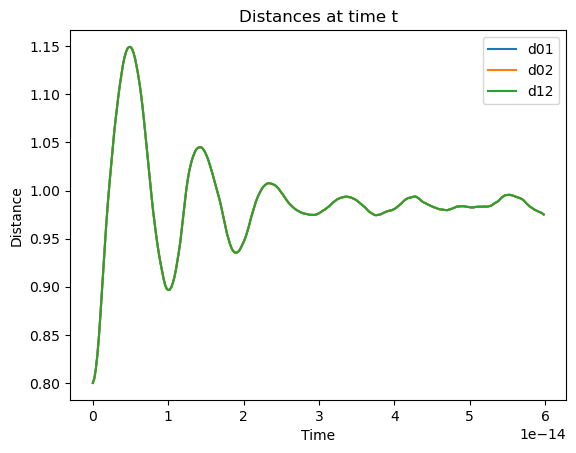

In [4]:
from matplotlib import pyplot as plt
(distance01,distance02,distance12,times) = main()

np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')

plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()